In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [69]:
file_path = '/home/tourmii/Documents/Projects/football-market-prediction/data/cleaned_player_data.csv'
df = pd.read_csv(file_path)

In [70]:
df.columns.to_list()

['playerId',
 'name',
 'contractUntil',
 'teamId',
 'teamName',
 'date_of_birth',
 'age',
 'height',
 'preferredFoot',
 'position',
 'firstSidePosition',
 'secondSidePosition',
 'nationalityId',
 'MarketValueCurrent',
 'preferredFootId',
 'positionId',
 'firstSidePositionId',
 'secondSidePositionId',
 'MarketValuePrevious',
 'MarketValueCurrency',
 'player_name',
 'rating',
 'totalRating',
 'countRating',
 'goals',
 'bigChancesCreated',
 'bigChancesMissed',
 'assists',
 'expectedAssists',
 'goalsAssistsSum',
 'accuratePasses',
 'inaccuratePasses',
 'totalPasses',
 'accuratePassesPercentage',
 'accurateOwnHalfPasses',
 'accurateOppositionHalfPasses',
 'accurateFinalThirdPasses',
 'keyPasses',
 'successfulDribbles',
 'successfulDribblesPercentage',
 'tackles',
 'interceptions',
 'yellowCards',
 'directRedCards',
 'redCards',
 'accurateCrosses',
 'accurateCrossesPercentage',
 'totalShots',
 'shotsOnTarget',
 'shotsOffTarget',
 'groundDuelsWon',
 'groundDuelsWonPercentage',
 'aerialDuelsWo

In [71]:
from column_groups import (
    COLUMN_GROUPS, 
    OUTFIELD_FEATURES,  
    GK_FEATURES, 
    get_columns_by_group 
)

In [72]:
groups = list(COLUMN_GROUPS.keys())
print(groups)

['identifiers_metadata', 'contract_market', 'demographics_physical', 'position_role', 'playing_time', 'rating_performance', 'attacking_output', 'chance_creation', 'passing_buildup', 'dribbling_carrying', 'defensive_actions', 'duels_physical', 'discipline_fouls', 'errors_mistakes', 'set_pieces_penalties', 'goalkeeping']


# EDA By Groups

## 1. Demographics

In [73]:
phys_cols = get_columns_by_group("demographics_physical")
print(f"Demographics & Physical columns: {phys_cols}")

Demographics & Physical columns: ['date_of_birth', 'age', 'height', 'preferredFoot', 'preferredFootId']


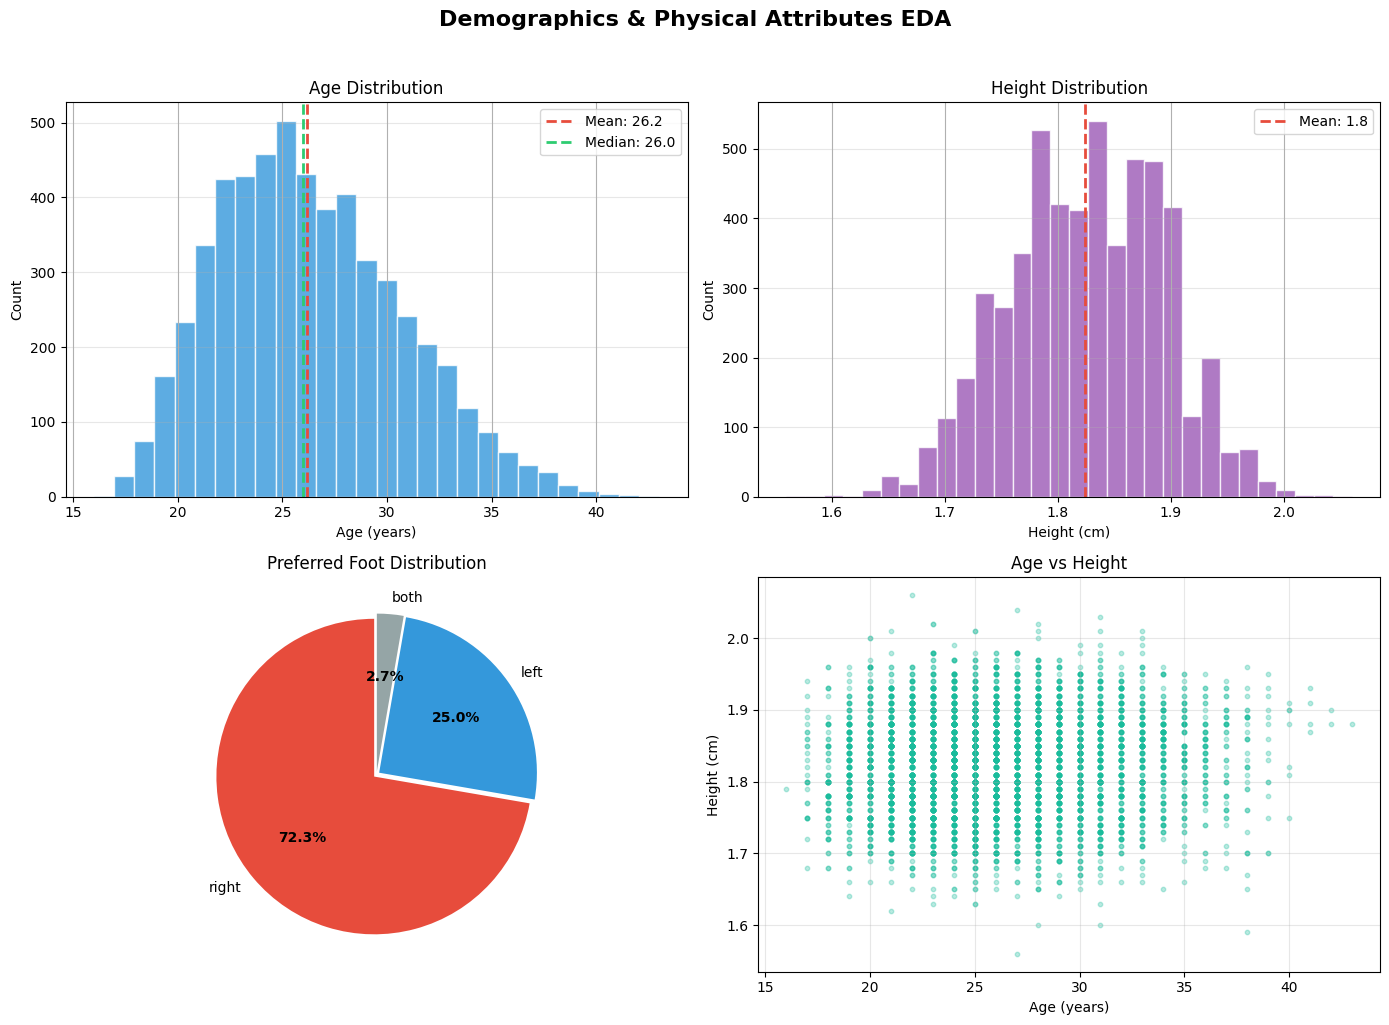

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Demographics & Physical Attributes EDA', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
if 'age' in df.columns:
    df['age'].hist(bins=28, ax=ax1, color='#3498db', edgecolor='white', alpha=0.8)
    ax1.axvline(df['age'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['age'].mean():.1f}")
    ax1.axvline(df['age'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['age'].median():.1f}")
    ax1.set_xlabel('Age (years)')
    ax1.set_ylabel('Count')
    ax1.set_title('Age Distribution')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
if 'height' in df.columns:
    df['height'].hist(bins=30, ax=ax2, color='#9b59b6', edgecolor='white', alpha=0.8)
    ax2.axvline(df['height'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['height'].mean():.1f}")
    ax2.set_xlabel('Height (cm)')
    ax2.set_ylabel('Count')
    ax2.set_title('Height Distribution')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
if 'preferredFoot' in df.columns:
    foot_counts = df['preferredFoot'].value_counts()
    colors = ['#e74c3c', '#3498db', '#95a5a6'][:len(foot_counts)]
    
    wedges, texts, autotexts = ax3.pie(
        foot_counts, 
        labels=foot_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.02] * len(foot_counts),
    )
    
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('black')
    
    ax3.set_title('Preferred Foot Distribution')
ax4 = axes[1, 1]
if 'age' in df.columns and 'height' in df.columns:
    ax4.scatter(df['age'], df['height'], alpha=0.3, c='#1abc9c', s=10)
    ax4.set_xlabel('Age (years)')
    ax4.set_ylabel('Height (cm)')
    ax4.set_title('Age vs Height')
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Contract Market

In [75]:
value = get_columns_by_group("contract_market")
print(f"Contract Market columns: {value}")

Contract Market columns: ['contractUntil', 'MarketValueCurrent', 'MarketValuePrevious', 'MarketValueCurrency']


In [76]:
df['delta_price'] = df['MarketValueCurrent'] - df['MarketValuePrevious']


Delta Price Summary Statistics
Count:              5,466
Mean:           12,036.22
Median:              0.00
Std Dev:     2,362,027.46
Min:       -20,000,000.00
Max:        30,000,000.00


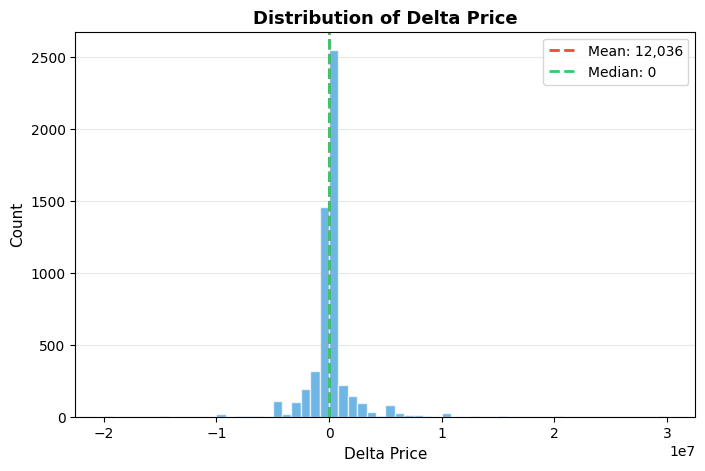

In [77]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')

data = df['delta_price'].dropna()
ax.hist(data, bins=60, color='#3498db', edgecolor='white', alpha=0.7)
ax.set_xlabel('Delta Price', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Delta Price', fontsize=13, fontweight='bold')
ax.axvline(data.mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {data.mean():,.0f}')
ax.axvline(data.median(), color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {data.median():,.0f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

print(f"\n{'='*40}")
print(f"Delta Price Summary Statistics")
print(f"{'='*40}")
print(f"Count:    {len(data):>15,}")
print(f"Mean:     {data.mean():>15,.2f}")
print(f"Median:   {data.median():>15,.2f}")
print(f"Std Dev:  {data.std():>15,.2f}")
print(f"Min:      {data.min():>15,.2f}")
print(f"Max:      {data.max():>15,.2f}")
print(f"{'='*40}")

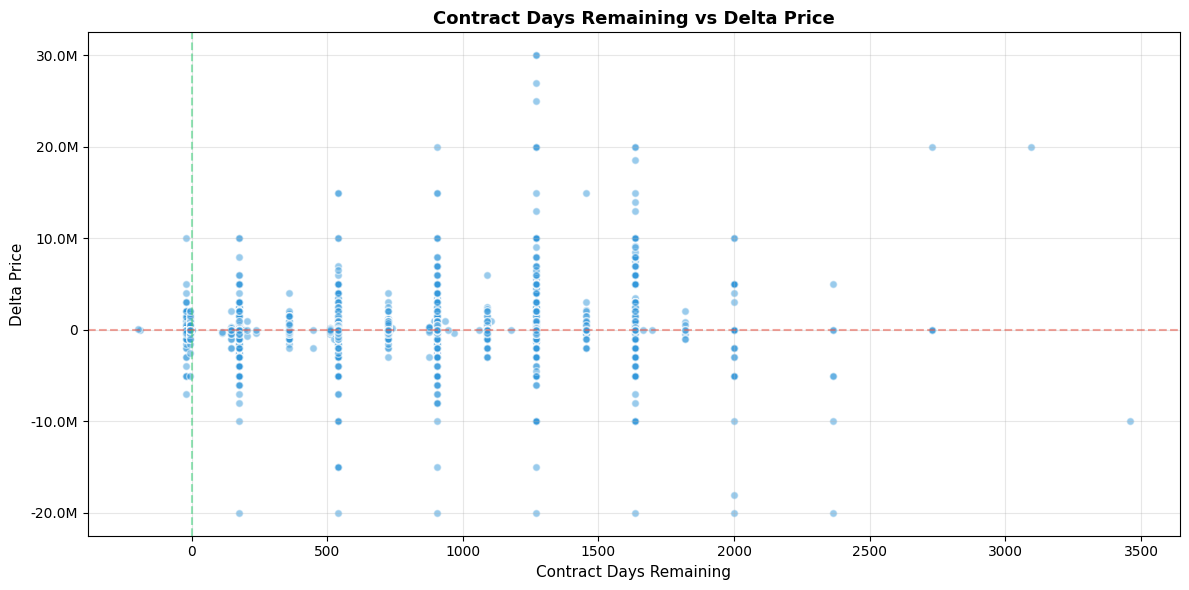

In [78]:
from datetime import datetime
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[['contractUntil', 'delta_price']].dropna().copy()
today = datetime.now()
plot_df['contract_days'] = (pd.to_datetime(plot_df['contractUntil'], format='mixed') - today).dt.days

ax.scatter(plot_df['contract_days'], plot_df['delta_price'], 
           alpha=0.5, color='#3498db', edgecolor='white', s=30)

def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(format_price))

ax.set_xlabel('Contract Days Remaining', fontsize=11)
ax.set_ylabel('Delta Price', fontsize=11)
ax.set_title('Contract Days Remaining vs Delta Price', fontsize=13, fontweight='bold')
ax.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax.axvline(0, color='#2ecc71', linestyle='--', alpha=0.5)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Position Role

In [79]:
pos_cols = get_columns_by_group("position_role")
print(f"Position columns: {pos_cols}")

Position columns: ['position', 'positionId', 'firstSidePosition', 'firstSidePositionId', 'secondSidePosition', 'secondSidePositionId']


In [80]:
def get_hybrid_type(position, first, second, role_map):
    roles = {position, first, second}
    groups = {role_map[r] for r in roles if r in role_map}

    if groups == {"GK"}:
        return "goalkeeper"

    if len(groups) == 1:
        return "non_hybrid"

    if groups == {"DEF", "MID"}:
        return "defensive_hybrid"

    if groups == {"MID", "ATT"}:
        return "attacking_hybrid"

    if groups == {"DEF", "ATT"}:
        return "extreme_hybrid"

    if groups == {"DEF", "MID", "ATT"}:
        return "full_hybrid"

    return "unknown"

In [81]:
from role_map import ROLE_GROUP_MAP

df['hybrid_type'] = df.apply(
    lambda row: get_hybrid_type(
        row['position'], 
        row['firstSidePosition'], 
        row['secondSidePosition'], 
        ROLE_GROUP_MAP
    ), axis=1
)

/tmp/ipykernel_14967/2189586617.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(plot_data, labels=plot_labels, patch_artist=True)


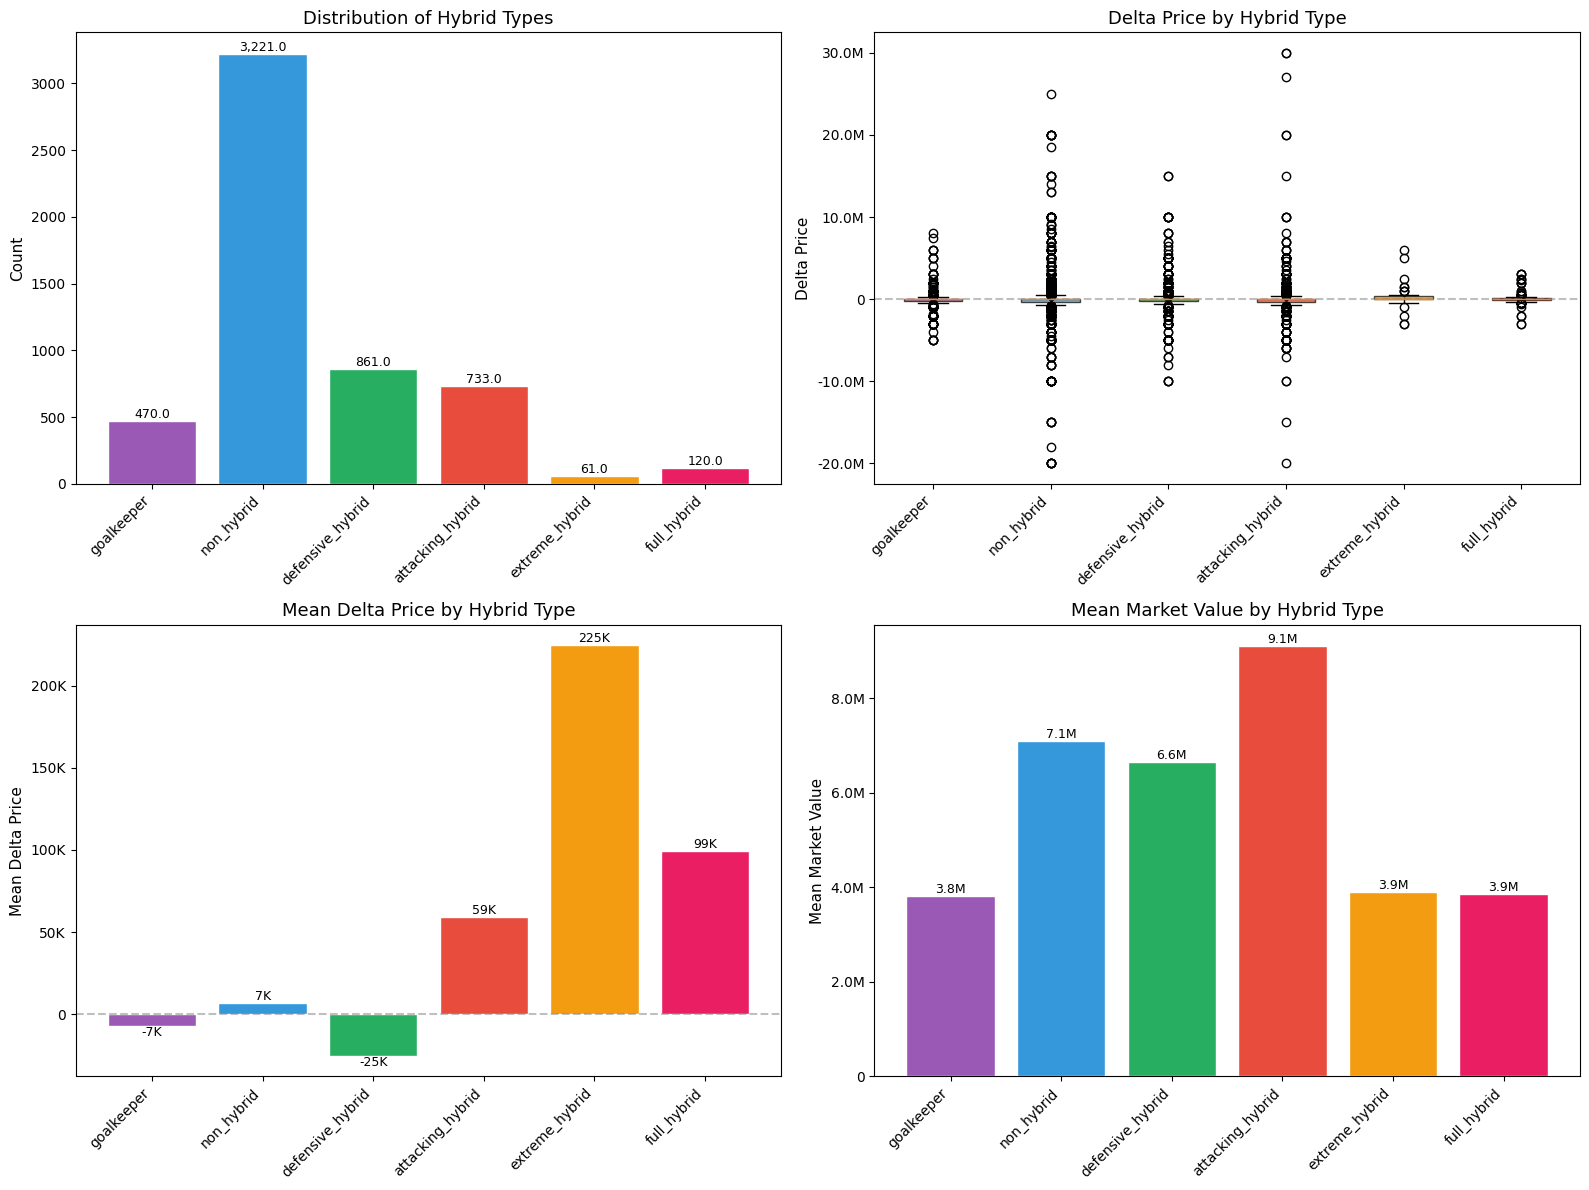

In [82]:
def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

hybrid_order = ['goalkeeper', 'non_hybrid', 'defensive_hybrid', 'attacking_hybrid', 'extreme_hybrid', 'full_hybrid', 'unknown']
colors = ['#9b59b6', '#3498db', '#27ae60', '#e74c3c', '#f39c12', '#e91e63', '#95a5a6']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Count by hybrid type
ax1 = axes[0, 0]
type_counts = df['hybrid_type'].value_counts().reindex(hybrid_order).dropna()
bars = ax1.bar(range(len(type_counts)), type_counts.values, color=colors[:len(type_counts)], edgecolor='white')
ax1.set_xticks(range(len(type_counts)))
ax1.set_xticklabels(type_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Distribution of Hybrid Types', fontsize=13)
for bar, val in zip(bars, type_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}', 
             ha='center', va='bottom', fontsize=9)

# 2. Delta Price by hybrid type (box plot)
ax2 = axes[0, 1]
plot_data = [df[df['hybrid_type'] == t]['delta_price'].dropna() for t in hybrid_order if t in df['hybrid_type'].values]
plot_labels = [t for t in hybrid_order if t in df['hybrid_type'].values]
bp = ax2.boxplot(plot_data, labels=plot_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xticklabels(plot_labels, rotation=45, ha='right')
ax2.set_ylabel('Delta Price', fontsize=11)
ax2.set_title('Delta Price by Hybrid Type', fontsize=13)
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# 3. Mean Delta Price by hybrid type
ax3 = axes[1, 0]
mean_delta = df.groupby('hybrid_type')['delta_price'].mean().reindex(hybrid_order).dropna()
bars = ax3.bar(range(len(mean_delta)), mean_delta.values, color=colors[:len(mean_delta)], edgecolor='white')
ax3.set_xticks(range(len(mean_delta)))
ax3.set_xticklabels(mean_delta.index, rotation=45, ha='right')
ax3.set_ylabel('Mean Delta Price', fontsize=11)
ax3.set_title('Mean Delta Price by Hybrid Type', fontsize=13)
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars, mean_delta.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val/1000:.0f}K', 
             ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

# 4. Market Value by hybrid type (if available)
ax4 = axes[1, 1]
if 'MarketValueCurrent' in df.columns:
    mean_mv = df.groupby('hybrid_type')['MarketValueCurrent'].mean().reindex(hybrid_order).dropna()
    bars = ax4.bar(range(len(mean_mv)), mean_mv.values, color=colors[:len(mean_mv)], edgecolor='white')
    ax4.set_xticks(range(len(mean_mv)))
    ax4.set_xticklabels(mean_mv.index, rotation=45, ha='right')
    ax4.set_ylabel('Mean Market Value', fontsize=11)
    ax4.set_title('Mean Market Value by Hybrid Type', fontsize=13)
    ax4.yaxis.set_major_formatter(FuncFormatter(format_price))
    
    for bar, val in zip(bars, mean_mv.values):
        if val >= 1_000_000:
            label = f'{val/1_000_000:.1f}M'
        elif val >= 1_000:
            label = f'{val/1_000:.0f}K'
        else:
            label = f'{val:.0f}'
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), label, 
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Playing Time

In [83]:
time_cols = get_columns_by_group('playing_time')
time_cols

['minutesPlayed', 'appearances', 'matchesStarted']

In [84]:
df[time_cols + ['name']]

minutesPlayed  appearances  matchesStarted                   name
0            3420.0           38            38.0            Joan García
1             675.0            8             8.0  Marc-André ter Stegen
2            1350.0           15            15.0      Wojciech Szczesny
3            2620.0           35            29.0            Pau Cubarsí
4            1575.0           29            14.0            Eric García
...             ...          ...             ...                    ...
5461         2218.0           31            25.0                 Hudson
5462         1108.0           30            10.0                Mandaca
5463          520.0            9             7.0                Rafinha
5464         1622.0           27            21.0          Gabriel Veron
5465          908.0           21             8.0        Gabriel Taliari

[5466 rows x 4 columns]

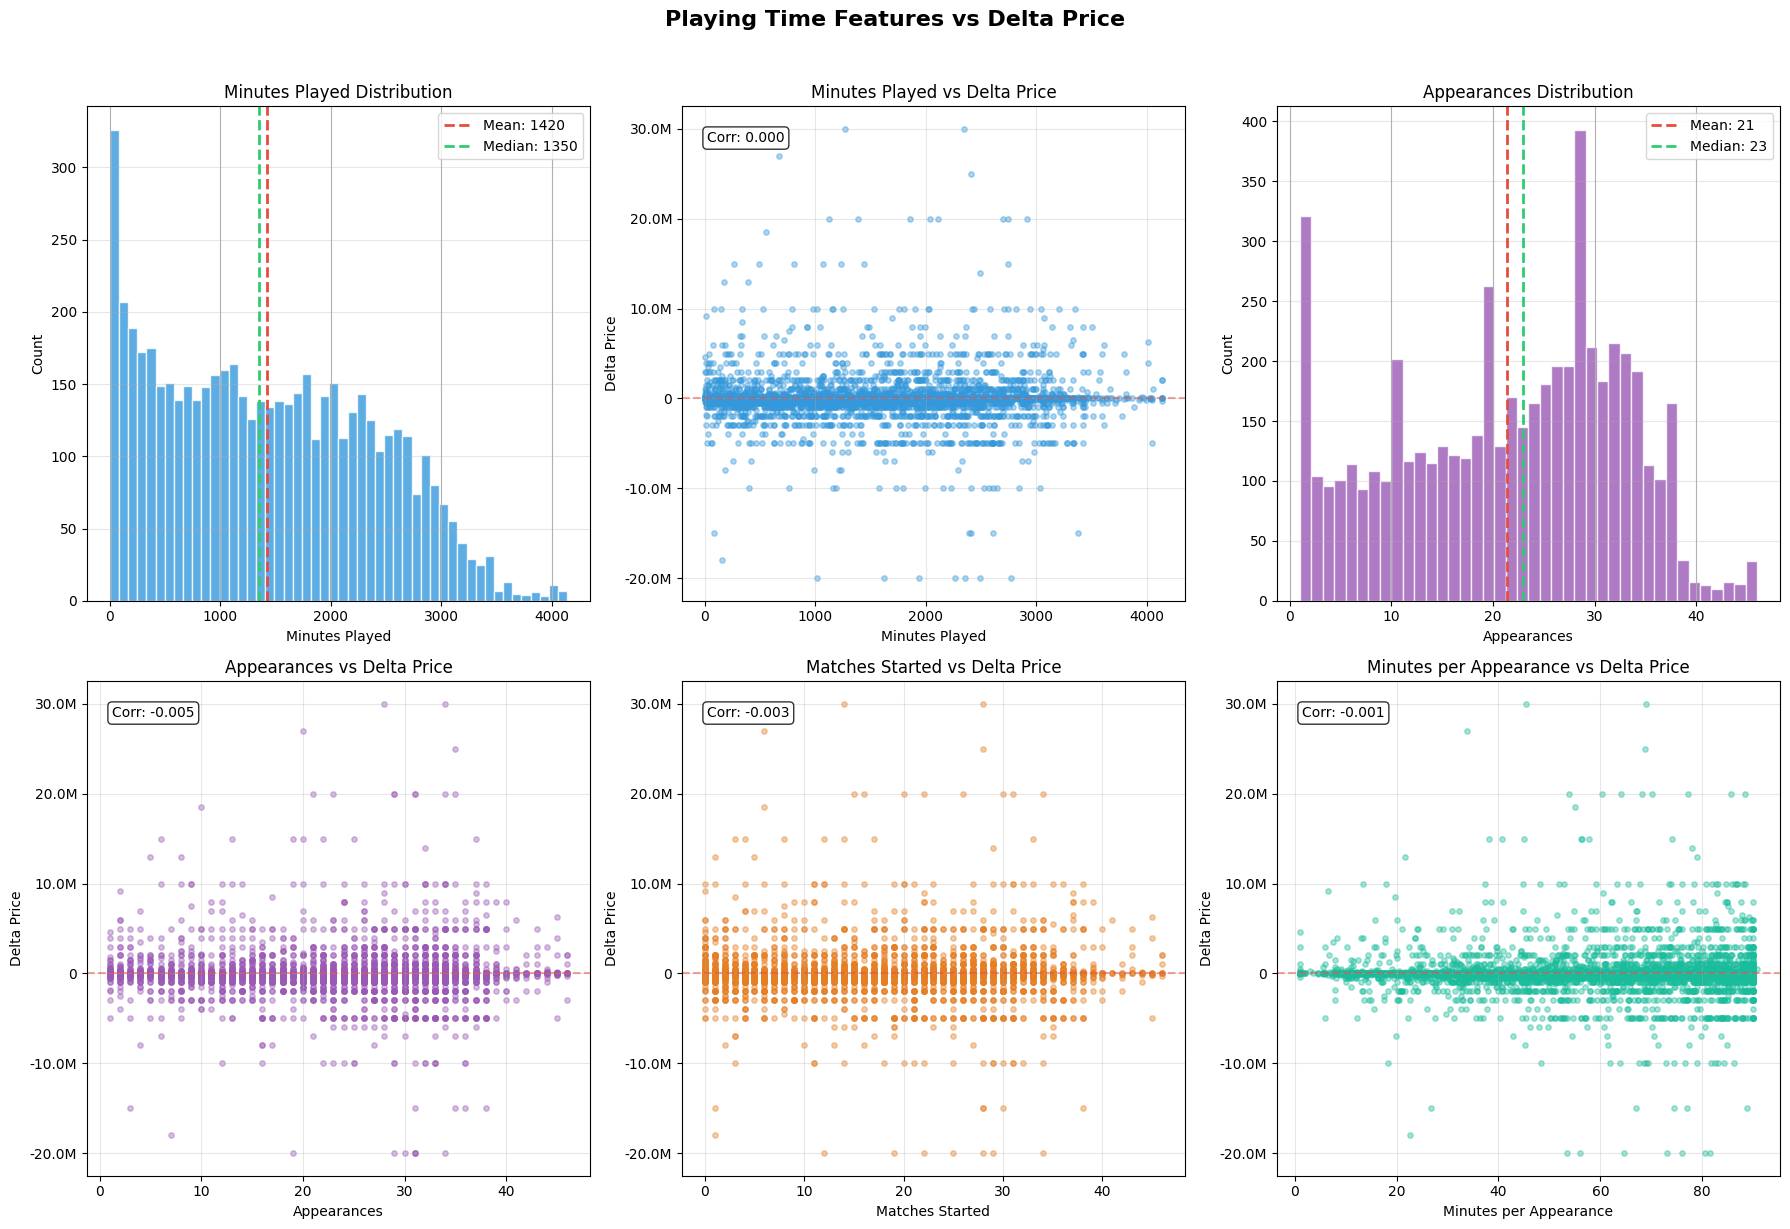


Playing Time Features - Summary Statistics

minutesPlayed:
  Count:       5,466
  Mean:      1,420.3
  Median:    1,349.5
  Std:         956.9
  Min:           1.0
  Max:       4,140.0

appearances:
  Count:       5,466
  Mean:         21.4
  Median:       23.0
  Std:          11.0
  Min:           1.0
  Max:          46.0

matchesStarted:
  Count:       5,466
  Mean:         15.8
  Median:       15.0
  Std:          11.2
  Min:           0.0
  Max:          46.0

Correlations with Delta Price
minutesPlayed       :   0.0002
appearances         :  -0.0052
matchesStarted      :  -0.0026


In [85]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Playing Time Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

# 1. Minutes Played Distribution
ax1 = axes[0, 0]
if 'minutesPlayed' in df.columns:
    df['minutesPlayed'].hist(bins=50, ax=ax1, color='#3498db', edgecolor='white', alpha=0.8)
    ax1.axvline(df['minutesPlayed'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['minutesPlayed'].mean():.0f}")
    ax1.axvline(df['minutesPlayed'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['minutesPlayed'].median():.0f}")
    ax1.set_xlabel('Minutes Played')
    ax1.set_ylabel('Count')
    ax1.set_title('Minutes Played Distribution')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

# 2. Minutes Played vs Delta Price (Scatter)
ax2 = axes[0, 1]
if 'minutesPlayed' in df.columns and 'delta_price' in df.columns:
    plot_df = df[['minutesPlayed', 'delta_price']].dropna()
    ax2.scatter(plot_df['minutesPlayed'], plot_df['delta_price'], alpha=0.4, c='#3498db', s=15)
    ax2.set_xlabel('Minutes Played')
    ax2.set_ylabel('Delta Price')
    ax2.set_title('Minutes Played vs Delta Price')
    ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
    ax2.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
    ax2.grid(alpha=0.3)
    
    # Add correlation
    corr = plot_df['minutesPlayed'].corr(plot_df['delta_price'])
    ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Appearances Distribution
ax3 = axes[0, 2]
if 'appearances' in df.columns:
    df['appearances'].hist(bins=40, ax=ax3, color='#9b59b6', edgecolor='white', alpha=0.8)
    ax3.axvline(df['appearances'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['appearances'].mean():.0f}")
    ax3.axvline(df['appearances'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['appearances'].median():.0f}")
    ax3.set_xlabel('Appearances')
    ax3.set_ylabel('Count')
    ax3.set_title('Appearances Distribution')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# 4. Appearances vs Delta Price (Scatter)
ax4 = axes[1, 0]
if 'appearances' in df.columns and 'delta_price' in df.columns:
    plot_df = df[['appearances', 'delta_price']].dropna()
    ax4.scatter(plot_df['appearances'], plot_df['delta_price'], alpha=0.4, c='#9b59b6', s=15)
    ax4.set_xlabel('Appearances')
    ax4.set_ylabel('Delta Price')
    ax4.set_title('Appearances vs Delta Price')
    ax4.yaxis.set_major_formatter(FuncFormatter(format_price))
    ax4.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
    ax4.grid(alpha=0.3)
    
    corr = plot_df['appearances'].corr(plot_df['delta_price'])
    ax4.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax4.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Matches Started vs Delta Price (Scatter)
ax5 = axes[1, 1]
if 'matchesStarted' in df.columns and 'delta_price' in df.columns:
    plot_df = df[['matchesStarted', 'delta_price']].dropna()
    ax5.scatter(plot_df['matchesStarted'], plot_df['delta_price'], alpha=0.4, c='#e67e22', s=15)
    ax5.set_xlabel('Matches Started')
    ax5.set_ylabel('Delta Price')
    ax5.set_title('Matches Started vs Delta Price')
    ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
    ax5.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
    ax5.grid(alpha=0.3)
    
    corr = plot_df['matchesStarted'].corr(plot_df['delta_price'])
    ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. Minutes per Appearance vs Delta Price
ax6 = axes[1, 2]
if 'minutesPlayed' in df.columns and 'appearances' in df.columns and 'delta_price' in df.columns:
    df_temp = df[['minutesPlayed', 'appearances', 'delta_price']].dropna()
    df_temp = df_temp[df_temp['appearances'] > 0]
    df_temp['mins_per_app'] = df_temp['minutesPlayed'] / df_temp['appearances']
    
    ax6.scatter(df_temp['mins_per_app'], df_temp['delta_price'], alpha=0.4, c='#1abc9c', s=15)
    ax6.set_xlabel('Minutes per Appearance')
    ax6.set_ylabel('Delta Price')
    ax6.set_title('Minutes per Appearance vs Delta Price')
    ax6.yaxis.set_major_formatter(FuncFormatter(format_price))
    ax6.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
    ax6.grid(alpha=0.3)
    
    corr = df_temp['mins_per_app'].corr(df_temp['delta_price'])
    ax6.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax6.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary Statistics
print(f"\n{'='*60}")
print(f"Playing Time Features - Summary Statistics")
print(f"{'='*60}")
for col in time_cols:
    if col in df.columns:
        data = df[col].dropna()
        print(f"\n{col}:")
        print(f"  Count:  {len(data):>10,}")
        print(f"  Mean:   {data.mean():>10,.1f}")
        print(f"  Median: {data.median():>10,.1f}")
        print(f"  Std:    {data.std():>10,.1f}")
        print(f"  Min:    {data.min():>10,.1f}")
        print(f"  Max:    {data.max():>10,.1f}")

print(f"\n{'='*60}")
print(f"Correlations with Delta Price")
print(f"{'='*60}")
for col in time_cols:
    if col in df.columns:
        corr = df[col].corr(df['delta_price'])
        print(f"{col:20s}: {corr:>8.4f}")

## 5. Rating Performance

In [86]:
rating_cols = get_columns_by_group('rating_performance')
rating_cols

['rating', 'totalRating', 'countRating', 'scoringFrequency', 'totwAppearances']

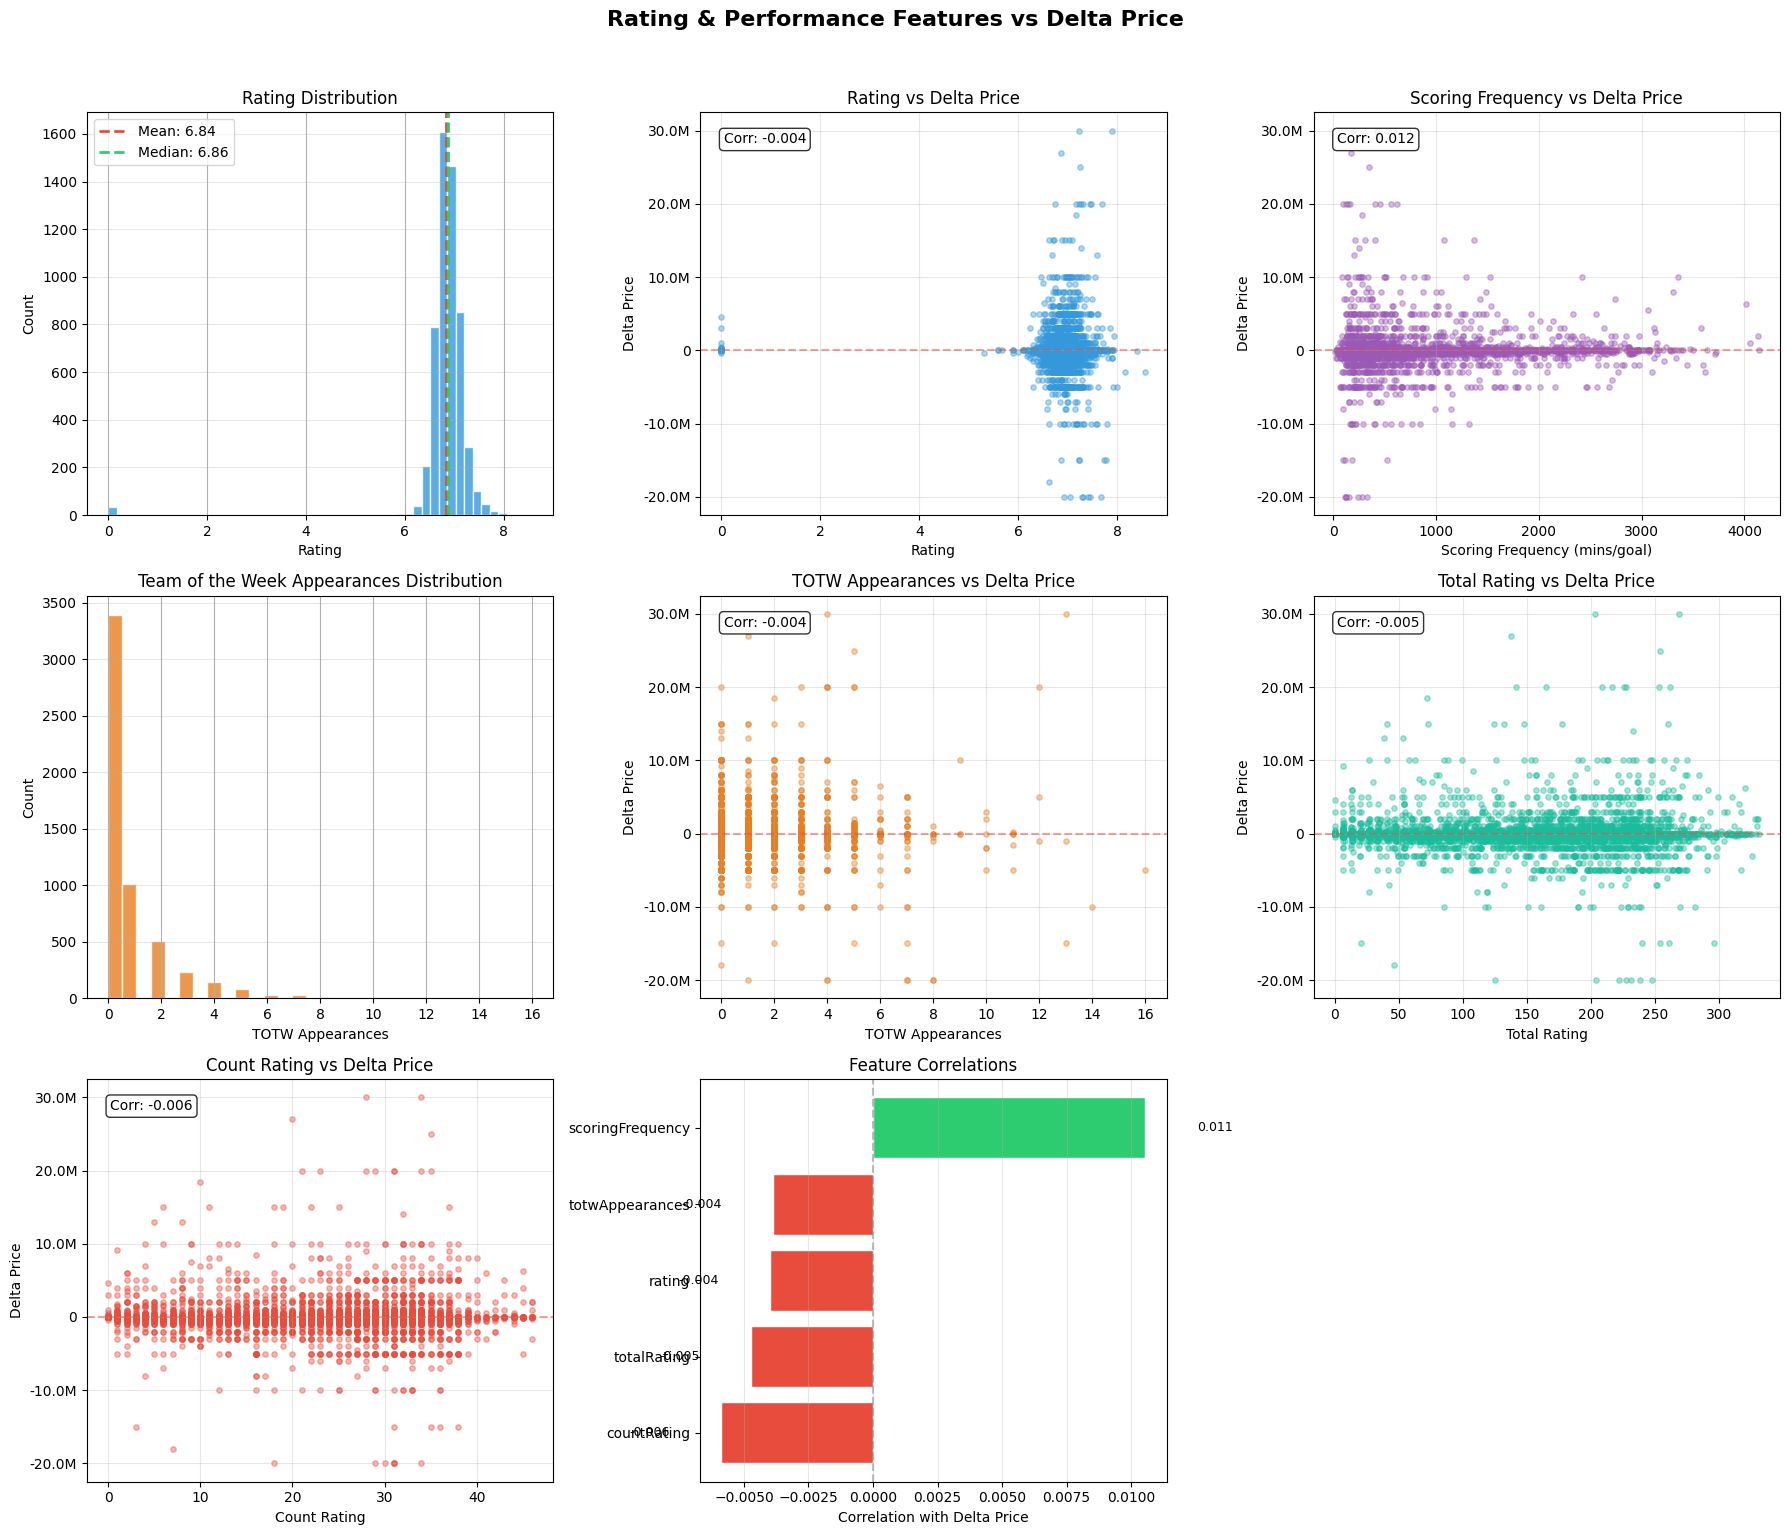


Rating & Performance Features - Summary Statistics

rating:
  Count:       5,466
  Mean:         6.84
  Median:       6.86
  Std:          0.59
  Min:          0.00
  Max:          8.57

totalRating:
  Count:       5,466
  Mean:       145.57
  Median:     155.20
  Std:         78.03
  Min:          0.00
  Max:        330.80

countRating:
  Count:       5,466
  Mean:        21.00
  Median:      22.00
  Std:         11.05
  Min:          0.00
  Max:         46.00

scoringFrequency:
  Count:       5,466
  Mean:       470.25
  Median:     183.00
  Std:        694.74
  Min:          0.00
  Max:      4,140.00

totwAppearances:
  Count:       5,466
  Mean:         0.82
  Median:       0.00
  Std:          1.48
  Min:          0.00
  Max:         16.00

Correlations with Delta Price
rating              :  -0.0040
totalRating         :  -0.0047
countRating         :  -0.0059
scoringFrequency    :   0.0106
totwAppearances     :  -0.0039


In [87]:
def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    return f'{x:.0f}'

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Rating & Performance Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
df['rating'].hist(bins=50, ax=ax1, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(df['rating'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['rating'].mean():.2f}")
ax1.axvline(df['rating'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['rating'].median():.2f}")
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title('Rating Distribution')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
plot_df = df[['rating', 'delta_price']].dropna()
ax2.scatter(plot_df['rating'], plot_df['delta_price'], alpha=0.4, c='#3498db', s=15)
ax2.set_xlabel('Rating')
ax2.set_ylabel('Delta Price')
ax2.set_title('Rating vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['rating'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['scoringFrequency', 'delta_price']].dropna()
plot_df = plot_df[plot_df['scoringFrequency'] > 0]
ax3.scatter(plot_df['scoringFrequency'], plot_df['delta_price'], alpha=0.4, c='#9b59b6', s=15)
ax3.set_xlabel('Scoring Frequency (mins/goal)')
ax3.set_ylabel('Delta Price')
ax3.set_title('Scoring Frequency vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['scoringFrequency'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
df['totwAppearances'].hist(bins=30, ax=ax4, color='#e67e22', edgecolor='white', alpha=0.8)
ax4.set_xlabel('TOTW Appearances')
ax4.set_ylabel('Count')
ax4.set_title('Team of the Week Appearances Distribution')
ax4.grid(axis='y', alpha=0.3)

ax5 = axes[1, 1]
plot_df = df[['totwAppearances', 'delta_price']].dropna()
ax5.scatter(plot_df['totwAppearances'], plot_df['delta_price'], alpha=0.4, c='#e67e22', s=15)
ax5.set_xlabel('TOTW Appearances')
ax5.set_ylabel('Delta Price')
ax5.set_title('TOTW Appearances vs Delta Price')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax5.grid(alpha=0.3)
corr = plot_df['totwAppearances'].corr(plot_df['delta_price'])
ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6 = axes[1, 2]
plot_df = df[['totalRating', 'delta_price']].dropna()
ax6.scatter(plot_df['totalRating'], plot_df['delta_price'], alpha=0.4, c='#1abc9c', s=15)
ax6.set_xlabel('Total Rating')
ax6.set_ylabel('Delta Price')
ax6.set_title('Total Rating vs Delta Price')
ax6.yaxis.set_major_formatter(FuncFormatter(format_price))
ax6.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax6.grid(alpha=0.3)
corr = plot_df['totalRating'].corr(plot_df['delta_price'])
ax6.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax6.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax7 = axes[2, 0]
plot_df = df[['countRating', 'delta_price']].dropna()
ax7.scatter(plot_df['countRating'], plot_df['delta_price'], alpha=0.4, c='#e74c3c', s=15)
ax7.set_xlabel('Count Rating')
ax7.set_ylabel('Delta Price')
ax7.set_title('Count Rating vs Delta Price')
ax7.yaxis.set_major_formatter(FuncFormatter(format_price))
ax7.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax7.grid(alpha=0.3)
corr = plot_df['countRating'].corr(plot_df['delta_price'])
ax7.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax7.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax8 = axes[2, 1]
corr_data = df[rating_cols + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in corr_data.values]
bars = ax8.barh(range(len(corr_data)), corr_data.values, color=colors, edgecolor='white')
ax8.set_yticks(range(len(corr_data)))
ax8.set_yticklabels(corr_data.index)
ax8.set_xlabel('Correlation with Delta Price')
ax8.set_title('Feature Correlations')
ax8.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax8.grid(axis='x', alpha=0.3)
for i, v in enumerate(corr_data.values):
    ax8.text(v + 0.002 if v >= 0 else v - 0.002, i, f'{v:.3f}', 
             va='center', ha='left' if v >= 0 else 'right', fontsize=9)

axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Rating & Performance Features - Summary Statistics")
print(f"{'='*60}")
for col in rating_cols:
    if col in df.columns:
        data = df[col].dropna()
        print(f"\n{col}:")
        print(f"  Count:  {len(data):>10,}")
        print(f"  Mean:   {data.mean():>10,.2f}")
        print(f"  Median: {data.median():>10,.2f}")
        print(f"  Std:    {data.std():>10,.2f}")
        print(f"  Min:    {data.min():>10,.2f}")
        print(f"  Max:    {data.max():>10,.2f}")

print(f"\n{'='*60}")
print(f"Correlations with Delta Price")
print(f"{'='*60}")
for col in rating_cols:
    if col in df.columns:
        corr = df[col].corr(df['delta_price'])
        print(f"{col:20s}: {corr:>8.4f}")

## 6. Attacking Outputs

In [88]:
att_cols = get_columns_by_group('attacking_output')
att_cols

['goals',
 'expectedGoals',
 'totalShots',
 'shotsOnTarget',
 'shotsOffTarget',
 'goalConversionPercentage',
 'goalsFromInsideTheBox',
 'goalsFromOutsideTheBox',
 'shotsFromInsideTheBox',
 'shotsFromOutsideTheBox',
 'headedGoals',
 'leftFootGoals',
 'rightFootGoals',
 'hitWoodwork',
 'bigChancesMissed']

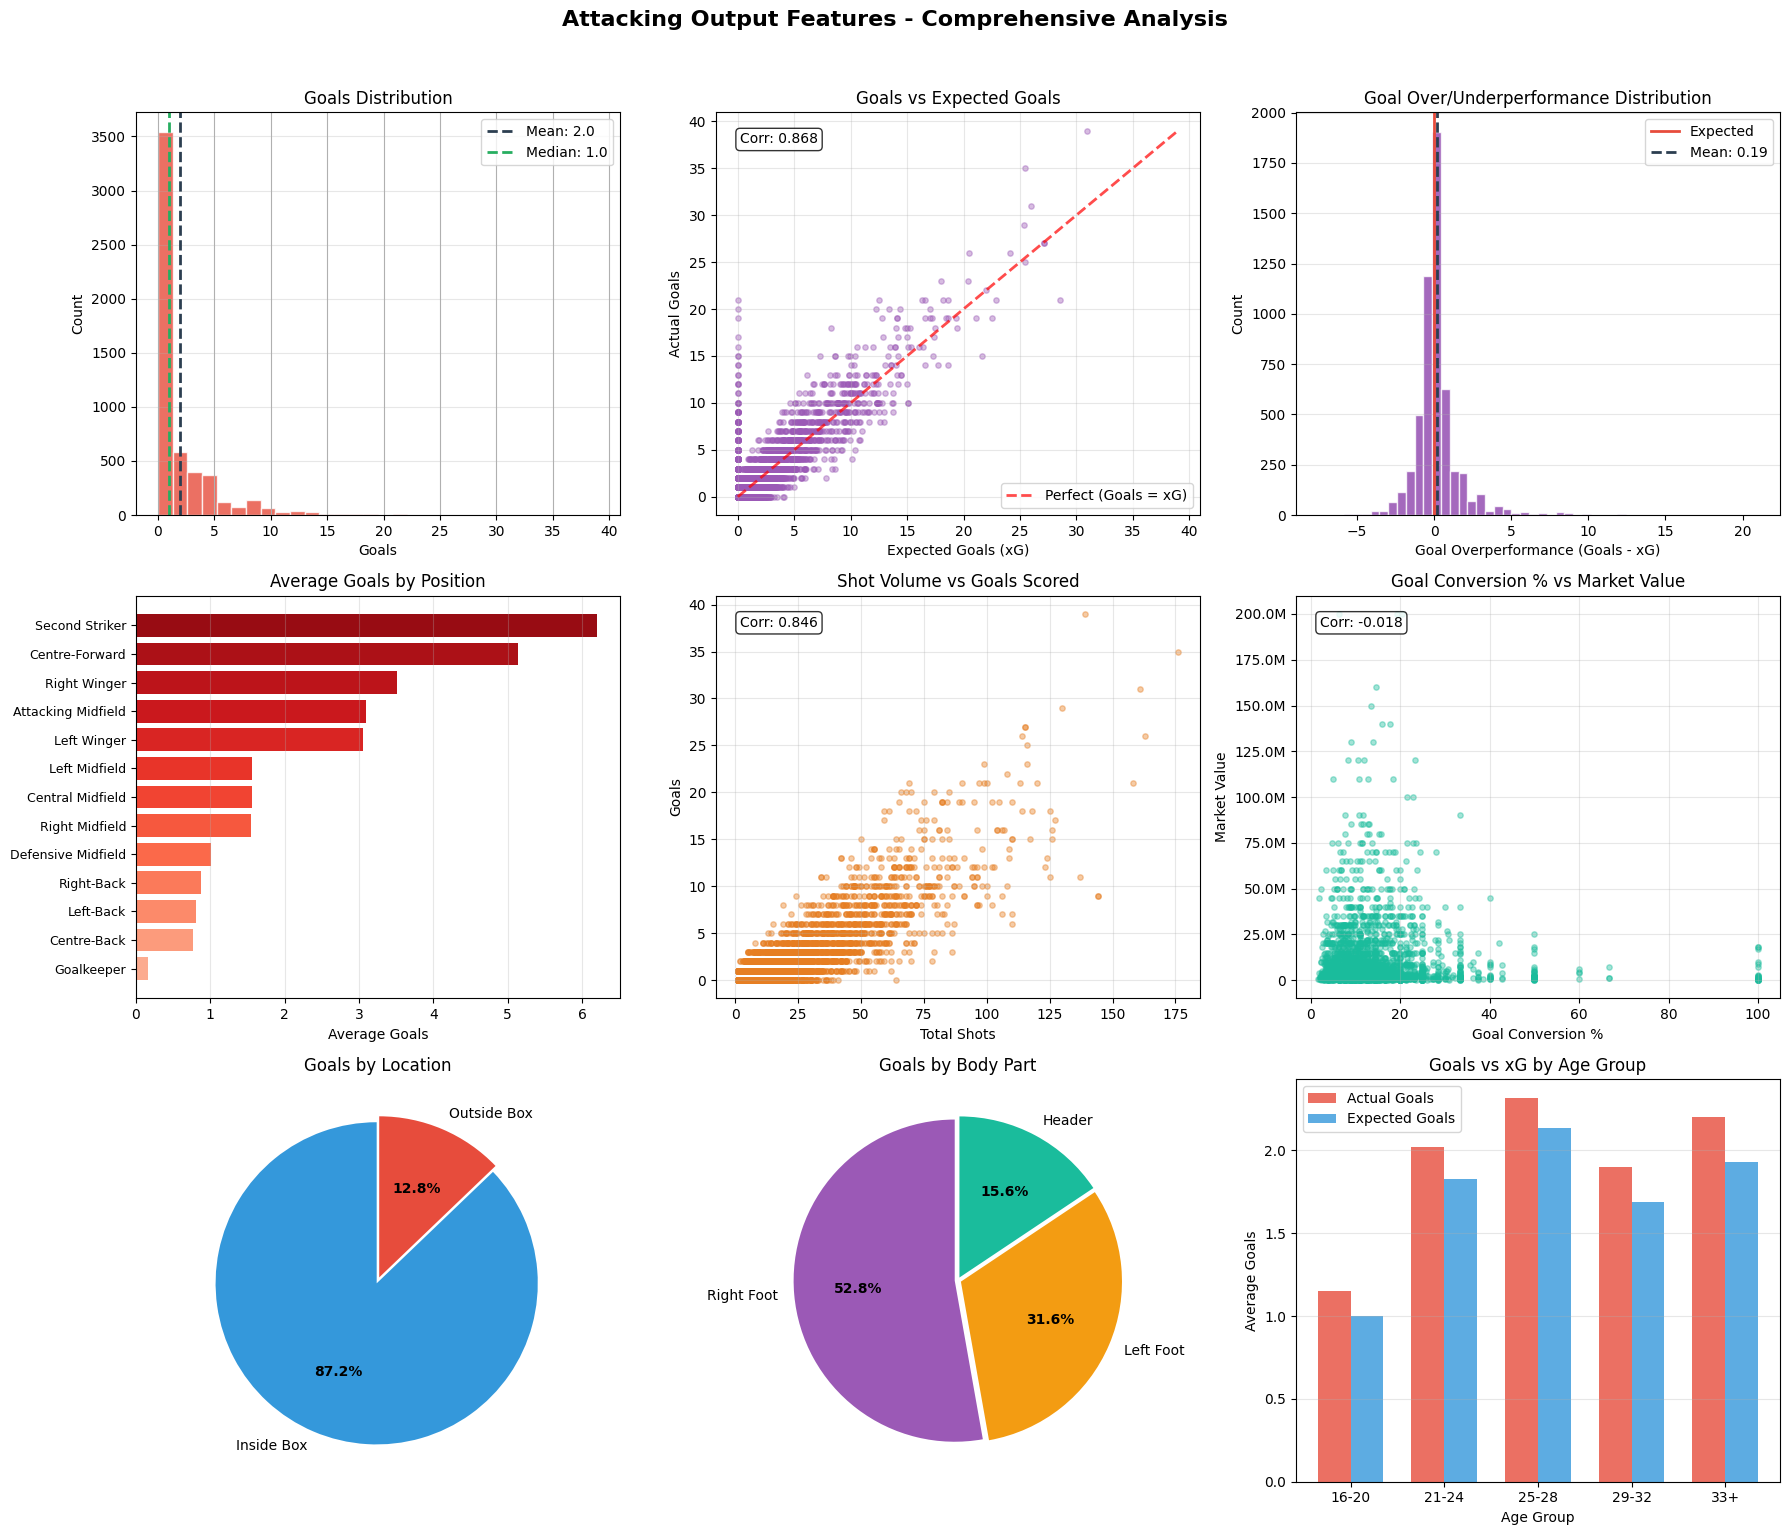


Key Attacking Insights

 Goal Overperformance Analysis:
   Players overperforming xG: 1,899 (34.7%)
   Players underperforming xG: 2,607 (47.7%)
   Average overperformance: 0.19 goals

 Top Positions by Average Goals:
   Second Striker: 6.20 goals/season
   Centre-Forward: 5.14 goals/season
   Right Winger: 3.52 goals/season
   Attacking Midfield: 3.10 goals/season
   Left Winger: 3.05 goals/season

 Shot Efficiency by Age Group:
   16-20: 10.2% conversion rate
   21-24: 10.5% conversion rate
   25-28: 10.9% conversion rate
   29-32: 10.8% conversion rate
   33+: 12.5% conversion rate

 Goal Breakdown by Location:
   Inside Box:   9,335 (87.2%)
   Outside Box:  1,375 (12.8%)

 Goal Breakdown by Body Part:
   Right Foot:  5,622 (52.5%)
   Left Foot:   3,363 (31.4%)
   Header:      1,664 (15.5%)

 Correlation with Market Value:
   expectedGoals: 0.3576
   shotsOnTarget: 0.3546
   totalShots: 0.3454
   goals: 0.3393
   shotsFromInsideTheBox: 0.3305


In [89]:
def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    return f'{x:.0f}'

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Attacking Output Features - Comprehensive Analysis', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
df['goals'].hist(bins=30, ax=ax1, color='#e74c3c', edgecolor='white', alpha=0.8)
ax1.axvline(df['goals'].mean(), color='#2c3e50', linestyle='--', lw=2, label=f"Mean: {df['goals'].mean():.1f}")
ax1.axvline(df['goals'].median(), color='#27ae60', linestyle='--', lw=2, label=f"Median: {df['goals'].median():.1f}")
ax1.set_xlabel('Goals')
ax1.set_ylabel('Count')
ax1.set_title('Goals Distribution')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
plot_df = df[['goals', 'expectedGoals']].dropna()
ax2.scatter(plot_df['expectedGoals'], plot_df['goals'], alpha=0.4, c='#9b59b6', s=15)
max_val = max(plot_df['expectedGoals'].max(), plot_df['goals'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, lw=2, label='Perfect (Goals = xG)')
ax2.set_xlabel('Expected Goals (xG)')
ax2.set_ylabel('Actual Goals')
ax2.set_title('Goals vs Expected Goals')
ax2.legend()
ax2.grid(alpha=0.3)
corr = plot_df['goals'].corr(plot_df['expectedGoals'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
df['goal_overperformance'] = df['goals'] - df['expectedGoals']
overperf = df['goal_overperformance'].dropna()
ax3.hist(overperf, bins=50, color='#8e44ad', edgecolor='white', alpha=0.8)
ax3.axvline(0, color='#e74c3c', linestyle='-', lw=2, label='Expected')
ax3.axvline(overperf.mean(), color='#2c3e50', linestyle='--', lw=2, label=f'Mean: {overperf.mean():.2f}')
ax3.set_xlabel('Goal Overperformance (Goals - xG)')
ax3.set_ylabel('Count')
ax3.set_title('Goal Over/Underperformance Distribution')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 0]
position_goals = df.groupby('position')['goals'].mean().sort_values(ascending=True)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(position_goals)))
bars = ax4.barh(range(len(position_goals)), position_goals.values, color=colors)
ax4.set_yticks(range(len(position_goals)))
ax4.set_yticklabels(position_goals.index, fontsize=9)
ax4.set_xlabel('Average Goals')
ax4.set_title('Average Goals by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
plot_df = df[['totalShots', 'goals']].dropna()
plot_df = plot_df[plot_df['totalShots'] > 0]
ax5.scatter(plot_df['totalShots'], plot_df['goals'], alpha=0.4, c='#e67e22', s=15)
ax5.set_xlabel('Total Shots')
ax5.set_ylabel('Goals')
ax5.set_title('Shot Volume vs Goals Scored')
ax5.grid(alpha=0.3)
corr = plot_df['totalShots'].corr(plot_df['goals'])
ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6 = axes[1, 2]
plot_df = df[['goalConversionPercentage', 'MarketValueCurrent']].dropna()
plot_df = plot_df[(plot_df['goalConversionPercentage'] > 0) & (plot_df['goalConversionPercentage'] <= 100)]
ax6.scatter(plot_df['goalConversionPercentage'], plot_df['MarketValueCurrent'], alpha=0.4, c='#1abc9c', s=15)
ax6.set_xlabel('Goal Conversion %')
ax6.set_ylabel('Market Value')
ax6.set_title('Goal Conversion % vs Market Value')
ax6.yaxis.set_major_formatter(FuncFormatter(format_price))
ax6.grid(alpha=0.3)
corr = plot_df['goalConversionPercentage'].corr(plot_df['MarketValueCurrent'])
ax6.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax6.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax7 = axes[2, 0]
location_data = [df['goalsFromInsideTheBox'].sum(), df['goalsFromOutsideTheBox'].sum()]
location_labels = ['Inside Box', 'Outside Box']
colors_loc = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax7.pie(location_data, labels=location_labels, autopct='%1.1f%%', 
                                    colors=colors_loc, startangle=90, explode=[0.02, 0.02])
for autotext in autotexts:
    autotext.set_fontweight('bold')
ax7.set_title('Goals by Location')

ax8 = axes[2, 1]
body_data = [df['rightFootGoals'].sum(), df['leftFootGoals'].sum(), df['headedGoals'].sum()]
body_labels = ['Right Foot', 'Left Foot', 'Header']
colors_body = ['#9b59b6', '#f39c12', '#1abc9c']
wedges, texts, autotexts = ax8.pie(body_data, labels=body_labels, autopct='%1.1f%%', 
                                    colors=colors_body, startangle=90, explode=[0.02, 0.02, 0.02])
for autotext in autotexts:
    autotext.set_fontweight('bold')
ax8.set_title('Goals by Body Part')

ax9 = axes[2, 2]
age_bins = [16, 21, 25, 29, 33, 40]
age_labels = ['16-20', '21-24', '25-28', '29-32', '33+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
age_goals = df.groupby('age_group', observed=True).agg({
    'goals': 'mean',
    'expectedGoals': 'mean'
}).reset_index()
x = np.arange(len(age_goals))
width = 0.35
bars1 = ax9.bar(x - width/2, age_goals['goals'], width, label='Actual Goals', color='#e74c3c', alpha=0.8)
bars2 = ax9.bar(x + width/2, age_goals['expectedGoals'], width, label='Expected Goals', color='#3498db', alpha=0.8)
ax9.set_xlabel('Age Group')
ax9.set_ylabel('Average Goals')
ax9.set_title('Goals vs xG by Age Group')
ax9.set_xticks(x)
ax9.set_xticklabels(age_goals['age_group'])
ax9.legend()
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Key Attacking Insights")
print(f"{'='*70}")

print(f"\n Goal Overperformance Analysis:")
overperf = df['goal_overperformance'].dropna()
print(f"   Players overperforming xG: {(overperf > 0).sum():,} ({(overperf > 0).mean()*100:.1f}%)")
print(f"   Players underperforming xG: {(overperf < 0).sum():,} ({(overperf < 0).mean()*100:.1f}%)")
print(f"   Average overperformance: {overperf.mean():.2f} goals")

print(f"\n Top Positions by Average Goals:")
pos_goals = df.groupby('position')['goals'].mean().sort_values(ascending=False).head(5)
for pos, goals in pos_goals.items():
    print(f"   {pos}: {goals:.2f} goals/season")

print(f"\n Shot Efficiency by Age Group:")
age_eff = df.groupby('age_group', observed=True).apply(
    lambda x: x['goals'].sum() / x['totalShots'].sum() * 100 if x['totalShots'].sum() > 0 else 0,
    include_groups=False
)
for age, eff in age_eff.items():
    print(f"   {age}: {eff:.1f}% conversion rate")

print(f"\n Goal Breakdown by Location:")
total_goals = df['goals'].sum()
inside = df['goalsFromInsideTheBox'].sum()
outside = df['goalsFromOutsideTheBox'].sum()
print(f"   Inside Box:  {inside:>6,.0f} ({inside/total_goals*100:.1f}%)")
print(f"   Outside Box: {outside:>6,.0f} ({outside/total_goals*100:.1f}%)")

print(f"\n Goal Breakdown by Body Part:")
right = df['rightFootGoals'].sum()
left = df['leftFootGoals'].sum()
head = df['headedGoals'].sum()
print(f"   Right Foot: {right:>6,.0f} ({right/total_goals*100:.1f}%)")
print(f"   Left Foot:  {left:>6,.0f} ({left/total_goals*100:.1f}%)")
print(f"   Header:     {head:>6,.0f} ({head/total_goals*100:.1f}%)")

print(f"\n Correlation with Market Value:")
att_cols = get_columns_by_group('attacking_output')
mv_corrs = df[att_cols + ['MarketValueCurrent']].corr()['MarketValueCurrent'].drop('MarketValueCurrent').sort_values(ascending=False)
for col, corr in mv_corrs.head(5).items():
    print(f"   {col}: {corr:.4f}")

## 7. Chance Creation

In [90]:
chance_cols = get_columns_by_group('chance_creation')
chance_cols

['assists',
 'expectedAssists',
 'goalsAssistsSum',
 'keyPasses',
 'bigChancesCreated',
 'passToAssist',
 'totalAttemptAssist']

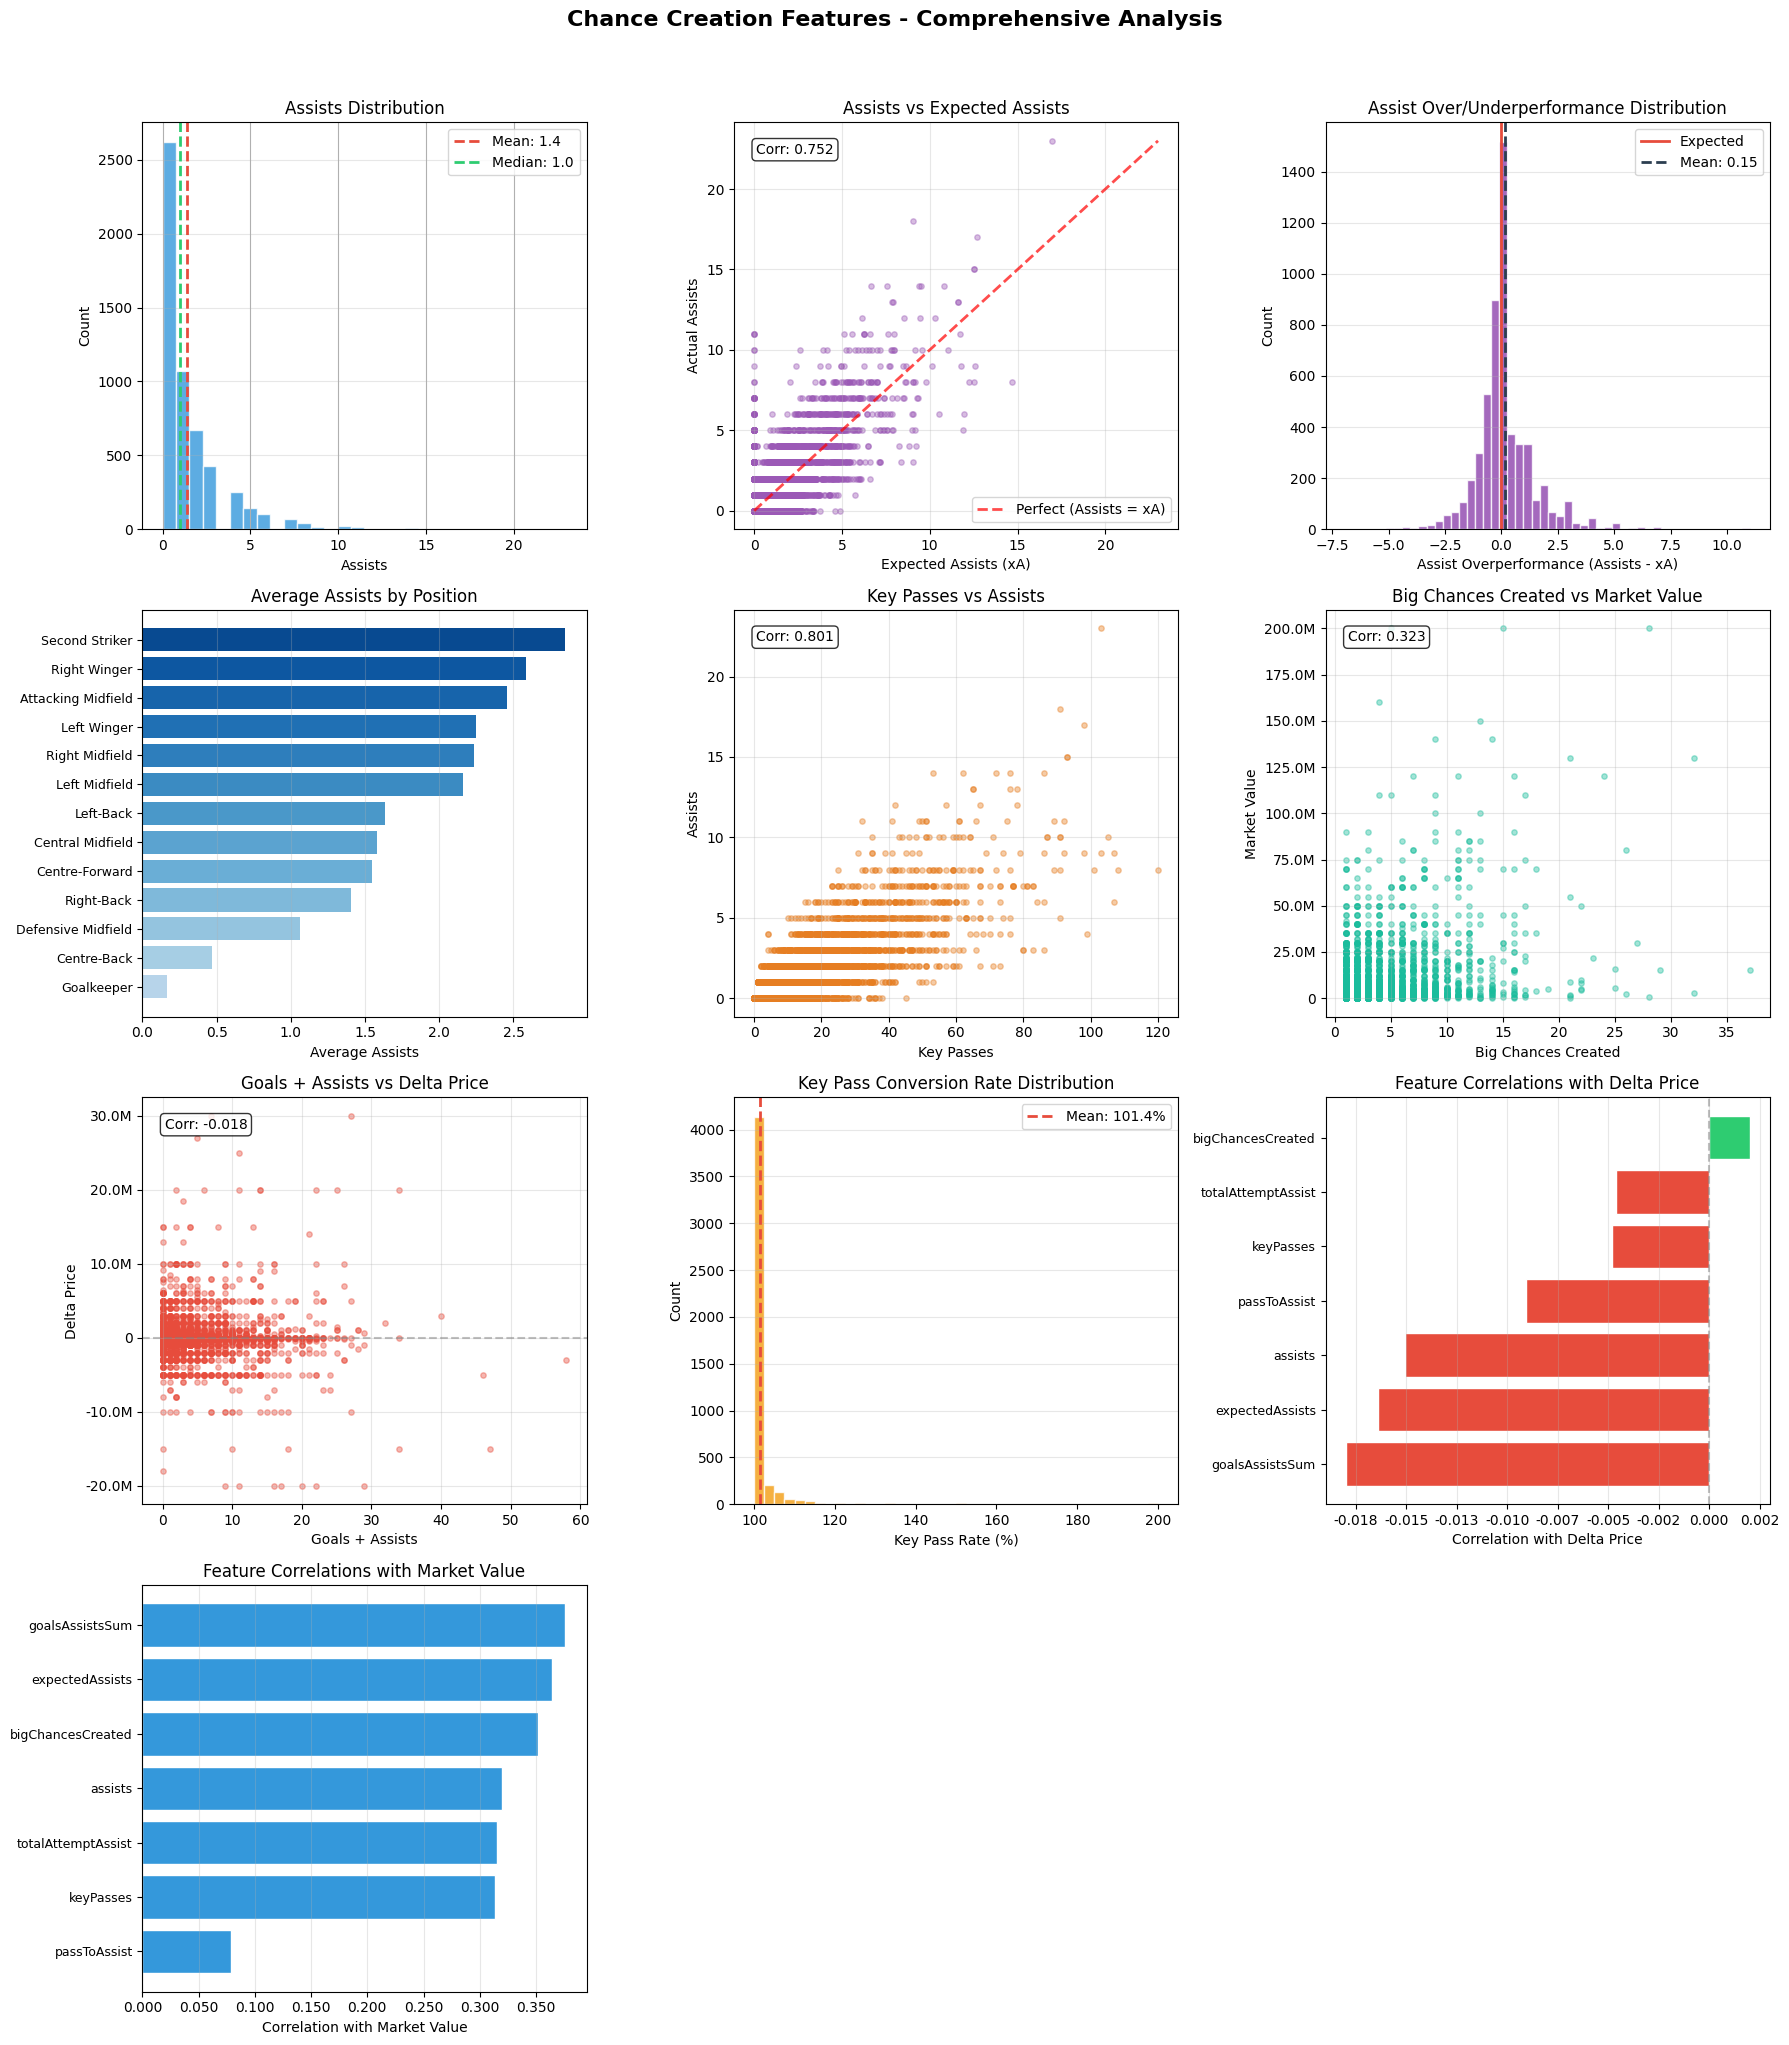


Key Chance Creation Insights

 Assist Overperformance Analysis:
   Players overperforming xA: 1,952 (35.7%)
   Players underperforming xA: 3,185 (58.3%)
   Average overperformance: 0.15 assists

 Top Positions by Average Assists:
   Second Striker: 2.85 assists/season
   Right Winger: 2.58 assists/season
   Attacking Midfield: 2.46 assists/season
   Left Winger: 2.25 assists/season
   Right Midfield: 2.23 assists/season

 Key Pass Efficiency:
   Average assists per key pass: 0.096
   Total key passes: 75,332
   Total assists: 7,620

 Big Chances Created Analysis:
   Total big chances created: 13,487
   Average per player: 2.47
   Players with 5+ big chances: 1,024 (18.7%)

 Correlation with Delta Price:
   bigChancesCreated: 0.0020
   totalAttemptAssist: -0.0046
   keyPasses: -0.0048
   passToAssist: -0.0091
   assists: -0.0151
   expectedAssists: -0.0164
   goalsAssistsSum: -0.0180

 Correlation with Market Value:
   goalsAssistsSum: 0.3762
   expectedAssists: 0.3643
   bigChancesCre

In [91]:
def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    return f'{x:.0f}'

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Chance Creation Features - Comprehensive Analysis', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
df['assists'].hist(bins=30, ax=ax1, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(df['assists'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['assists'].mean():.1f}")
ax1.axvline(df['assists'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['assists'].median():.1f}")
ax1.set_xlabel('Assists')
ax1.set_ylabel('Count')
ax1.set_title('Assists Distribution')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
plot_df = df[['assists', 'expectedAssists']].dropna()
ax2.scatter(plot_df['expectedAssists'], plot_df['assists'], alpha=0.4, c='#9b59b6', s=15)
max_val = max(plot_df['expectedAssists'].max(), plot_df['assists'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, lw=2, label='Perfect (Assists = xA)')
ax2.set_xlabel('Expected Assists (xA)')
ax2.set_ylabel('Actual Assists')
ax2.set_title('Assists vs Expected Assists')
ax2.legend()
ax2.grid(alpha=0.3)
corr = plot_df['assists'].corr(plot_df['expectedAssists'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
df['assist_overperformance'] = df['assists'] - df['expectedAssists']
overperf = df['assist_overperformance'].dropna()
ax3.hist(overperf, bins=50, color='#8e44ad', edgecolor='white', alpha=0.8)
ax3.axvline(0, color='#e74c3c', linestyle='-', lw=2, label='Expected')
ax3.axvline(overperf.mean(), color='#2c3e50', linestyle='--', lw=2, label=f'Mean: {overperf.mean():.2f}')
ax3.set_xlabel('Assist Overperformance (Assists - xA)')
ax3.set_ylabel('Count')
ax3.set_title('Assist Over/Underperformance Distribution')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 0]
position_assists = df.groupby('position')['assists'].mean().sort_values(ascending=True)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(position_assists)))
bars = ax4.barh(range(len(position_assists)), position_assists.values, color=colors)
ax4.set_yticks(range(len(position_assists)))
ax4.set_yticklabels(position_assists.index, fontsize=9)
ax4.set_xlabel('Average Assists')
ax4.set_title('Average Assists by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
plot_df = df[['keyPasses', 'assists']].dropna()
ax5.scatter(plot_df['keyPasses'], plot_df['assists'], alpha=0.4, c='#e67e22', s=15)
ax5.set_xlabel('Key Passes')
ax5.set_ylabel('Assists')
ax5.set_title('Key Passes vs Assists')
ax5.grid(alpha=0.3)
corr = plot_df['keyPasses'].corr(plot_df['assists'])
ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6 = axes[1, 2]
plot_df = df[['bigChancesCreated', 'MarketValueCurrent']].dropna()
plot_df = plot_df[plot_df['bigChancesCreated'] > 0]
ax6.scatter(plot_df['bigChancesCreated'], plot_df['MarketValueCurrent'], alpha=0.4, c='#1abc9c', s=15)
ax6.set_xlabel('Big Chances Created')
ax6.set_ylabel('Market Value')
ax6.set_title('Big Chances Created vs Market Value')
ax6.yaxis.set_major_formatter(FuncFormatter(format_price))
ax6.grid(alpha=0.3)
corr = plot_df['bigChancesCreated'].corr(plot_df['MarketValueCurrent'])
ax6.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax6.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax7 = axes[2, 0]
plot_df = df[['goalsAssistsSum', 'delta_price']].dropna()
ax7.scatter(plot_df['goalsAssistsSum'], plot_df['delta_price'], alpha=0.4, c='#e74c3c', s=15)
ax7.set_xlabel('Goals + Assists')
ax7.set_ylabel('Delta Price')
ax7.set_title('Goals + Assists vs Delta Price')
ax7.yaxis.set_major_formatter(FuncFormatter(format_price))
ax7.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax7.grid(alpha=0.3)
corr = plot_df['goalsAssistsSum'].corr(plot_df['delta_price'])
ax7.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax7.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax8 = axes[2, 1]
plot_df = df[['keyPasses', 'totalAttemptAssist']].dropna()
plot_df = plot_df[plot_df['totalAttemptAssist'] > 0]
plot_df['key_pass_rate'] = plot_df['keyPasses'] / plot_df['totalAttemptAssist'] * 100
ax8.hist(plot_df['key_pass_rate'], bins=40, color='#f39c12', edgecolor='white', alpha=0.8)
ax8.axvline(plot_df['key_pass_rate'].mean(), color='#e74c3c', linestyle='--', lw=2, 
            label=f"Mean: {plot_df['key_pass_rate'].mean():.1f}%")
ax8.set_xlabel('Key Pass Rate (%)')
ax8.set_ylabel('Count')
ax8.set_title('Key Pass Conversion Rate Distribution')
ax8.legend()
ax8.grid(axis='y', alpha=0.3)

ax9 = axes[2, 2]
corr_data = df[chance_cols + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in corr_data.values]
bars = ax9.barh(range(len(corr_data)), corr_data.values, color=colors, edgecolor='white')
ax9.set_yticks(range(len(corr_data)))
ax9.set_yticklabels(corr_data.index, fontsize=9)
ax9.set_xlabel('Correlation with Delta Price')
ax9.set_title('Feature Correlations with Delta Price')
ax9.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax9.grid(axis='x', alpha=0.3)
ax9.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))

ax10 = axes[3, 0]
mv_corr_data = df[chance_cols + ['MarketValueCurrent']].corr()['MarketValueCurrent'].drop('MarketValueCurrent').sort_values()
colors_mv = ['#e74c3c' if v < 0 else '#3498db' for v in mv_corr_data.values]
bars = ax10.barh(range(len(mv_corr_data)), mv_corr_data.values, color=colors_mv, edgecolor='white')
ax10.set_yticks(range(len(mv_corr_data)))
ax10.set_yticklabels(mv_corr_data.index, fontsize=9)
ax10.set_xlabel('Correlation with Market Value')
ax10.set_title('Feature Correlations with Market Value')
ax10.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax10.grid(axis='x', alpha=0.3)
ax10.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))

axes[3, 1].axis('off')
axes[3, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Key Chance Creation Insights")
print(f"{'='*70}")

print(f"\n Assist Overperformance Analysis:")
overperf = df['assist_overperformance'].dropna()
print(f"   Players overperforming xA: {(overperf > 0).sum():,} ({(overperf > 0).mean()*100:.1f}%)")
print(f"   Players underperforming xA: {(overperf < 0).sum():,} ({(overperf < 0).mean()*100:.1f}%)")
print(f"   Average overperformance: {overperf.mean():.2f} assists")

print(f"\n Top Positions by Average Assists:")
pos_assists = df.groupby('position')['assists'].mean().sort_values(ascending=False).head(5)
for pos, assists in pos_assists.items():
    print(f"   {pos}: {assists:.2f} assists/season")

print(f"\n Key Pass Efficiency:")
kp_df = df[['keyPasses', 'assists', 'totalAttemptAssist']].dropna()
kp_df = kp_df[kp_df['keyPasses'] > 0]
kp_df['assist_per_key_pass'] = kp_df['assists'] / kp_df['keyPasses']
print(f"   Average assists per key pass: {kp_df['assist_per_key_pass'].mean():.3f}")
print(f"   Total key passes: {df['keyPasses'].sum():,.0f}")
print(f"   Total assists: {df['assists'].sum():,.0f}")

print(f"\n Big Chances Created Analysis:")
bcc = df['bigChancesCreated'].dropna()
print(f"   Total big chances created: {bcc.sum():,.0f}")
print(f"   Average per player: {bcc.mean():.2f}")
print(f"   Players with 5+ big chances: {(bcc >= 5).sum():,} ({(bcc >= 5).mean()*100:.1f}%)")

print(f"\n Correlation with Delta Price:")
dp_corrs = df[chance_cols + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values(ascending=False)
for col, corr in dp_corrs.items():
    print(f"   {col}: {corr:.4f}")

print(f"\n Correlation with Market Value:")
mv_corrs = df[chance_cols + ['MarketValueCurrent']].corr()['MarketValueCurrent'].drop('MarketValueCurrent').sort_values(ascending=False)
for col, corr in mv_corrs.items():
    print(f"   {col}: {corr:.4f}")

# Feature Engineering EDA

Cross-group feature engineering for football-insightful analysis:
1. **Defensive Profile** - defensive efficiency by position role
2. **Attacking Contribution** - goal involvement metrics  
3. **Ball Progression** - progressive play metrics
4. **Physical Dominance** - duel success by position
5. **Risk Profile** - discipline and error metrics
6. **Set Piece Specialist** - dead ball contribution

In [ ]:
def create_defensive_features(df):
    features = df.copy()
    
    features['tackle_success_rate'] = np.where(
        features['tackles'] > 0,
        features['tacklesWon'] / features['tackles'] * 100,
        0
    )
    
    features['defensive_actions_total'] = (
        features['tackles'] + features['interceptions'] + 
        features['clearances'] + features['blockedShots']
    )
    
    features['defensive_actions_per_90'] = np.where(
        features['minutesPlayed'] > 0,
        features['defensive_actions_total'] / features['minutesPlayed'] * 90,
        0
    )
    
    features['error_rate'] = np.where(
        features['defensive_actions_total'] > 0,
        (features['errorLeadToGoal'] + features['errorLeadToShot']) / features['defensive_actions_total'] * 100,
        0
    )
    
    features['clean_defensive_actions'] = (
        features['defensive_actions_total'] - 
        features['errorLeadToGoal'] * 10 - 
        features['errorLeadToShot'] * 3
    )
    
    features['ball_recovery_rate'] = np.where(
        features['minutesPlayed'] > 0,
        features['ballRecovery'] / features['minutesPlayed'] * 90,
        0
    )
    
    return features

def create_attacking_features(df):
    features = df.copy()
    
    features['goal_involvement'] = features['goals'] + features['assists']
    
    features['goal_involvement_per_90'] = np.where(
        features['minutesPlayed'] > 0,
        features['goal_involvement'] / features['minutesPlayed'] * 90,
        0
    )
    
    features['xG_involvement'] = features['expectedGoals'] + features['expectedAssists']
    
    features['overperformance_total'] = features['goal_involvement'] - features['xG_involvement']
    
    features['shot_creation_rate'] = np.where(
        features['minutesPlayed'] > 0,
        (features['totalShots'] + features['keyPasses']) / features['minutesPlayed'] * 90,
        0
    )
    
    features['big_chance_involvement'] = features['bigChancesCreated'] + np.where(
        features['bigChancesMissed'] > 0,
        features['goals'] / (features['goals'] + features['bigChancesMissed']),
        0
    )
    
    features['clinical_finishing'] = np.where(
        features['expectedGoals'] > 0,
        features['goals'] / features['expectedGoals'],
        0
    )
    
    return features

def create_progression_features(df):
    features = df.copy()
    
    features['progressive_passes'] = (
        features['accurateOppositionHalfPasses'] + 
        features['accurateFinalThirdPasses'] +
        features['accurateLongBalls']
    )
    
    features['progressive_passes_per_90'] = np.where(
        features['minutesPlayed'] > 0,
        features['progressive_passes'] / features['minutesPlayed'] * 90,
        0
    )
    
    features['ball_progression_index'] = (
        features['progressive_passes'] + 
        features['successfulDribbles'] * 2 +
        features['possessionWonAttThird'] * 3
    )
    
    features['possession_efficiency'] = np.where(
        features['touches'] > 0,
        (features['touches'] - features['possessionLost']) / features['touches'] * 100,
        0
    )
    
    features['dribble_success_rate'] = features['successfulDribblesPercentage']
    
    features['pass_risk_reward'] = np.where(
        features['totalPasses'] > 0,
        (features['keyPasses'] + features['bigChancesCreated']) / features['totalPasses'] * 100,
        0
    )
    
    return features

def create_physical_features(df):
    features = df.copy()
    
    features['duel_dominance'] = (
        features['totalDuelsWon'] - features['duelLost']
    )
    
    features['aerial_dominance'] = (
        features['aerialDuelsWon'] - features['aerialLost']
    )
    
    features['ground_duel_rate'] = features['groundDuelsWonPercentage']
    features['aerial_duel_rate'] = features['aerialDuelsWonPercentage']
    
    features['physical_score'] = (
        features['totalDuelsWonPercentage'] * 0.4 +
        features['aerialDuelsWonPercentage'] * 0.3 +
        features['groundDuelsWonPercentage'] * 0.3
    )
    
    features['contest_intensity'] = np.where(
        features['minutesPlayed'] > 0,
        features['totalContest'] / features['minutesPlayed'] * 90,
        0
    )
    
    return features

def create_risk_features(df):
    features = df.copy()
    
    features['cards_total'] = features['yellowCards'] + features['redCards'] * 2
    
    features['cards_per_90'] = np.where(
        features['minutesPlayed'] > 0,
        features['cards_total'] / features['minutesPlayed'] * 90,
        0
    )
    
    features['foul_ratio'] = np.where(
        features['fouls'] + features['wasFouled'] > 0,
        features['wasFouled'] / (features['fouls'] + features['wasFouled']),
        0.5
    )
    
    features['error_impact'] = (
        features['errorLeadToGoal'] * 10 +
        features['errorLeadToShot'] * 3 +
        features['ownGoals'] * 15
    )
    
    features['discipline_score'] = 100 - (
        features['yellowCards'] * 5 +
        features['redCards'] * 20 +
        features['fouls'] * 0.5
    )
    features['discipline_score'] = features['discipline_score'].clip(0, 100)
    
    features['risk_adjusted_value'] = np.where(
        features['error_impact'] > 0,
        features['MarketValueCurrent'] / (1 + features['error_impact'] * 0.01),
        features['MarketValueCurrent']
    )
    
    return features

def create_setpiece_features(df):
    features = df.copy()
    
    features['penalty_reliability'] = np.where(
        features['penaltiesTaken'] > 0,
        features['penaltyGoals'] / features['penaltiesTaken'] * 100,
        np.nan
    )
    
    features['setpiece_goals'] = features['penaltyGoals'] + features['freeKickGoal']
    
    features['setpiece_contribution'] = np.where(
        features['goals'] > 0,
        features['setpiece_goals'] / features['goals'] * 100,
        0
    )
    
    features['penalty_involvement'] = features['penaltyWon'] + features['penaltiesTaken']
    
    features['open_play_goals'] = features['goals'] - features['setpiece_goals']
    
    features['open_play_ratio'] = np.where(
        features['goals'] > 0,
        features['open_play_goals'] / features['goals'] * 100,
        0
    )
    
    return features

df = create_defensive_features(df)
df = create_attacking_features(df)
df = create_progression_features(df)
df = create_physical_features(df)
df = create_risk_features(df)
df = create_setpiece_features(df)

print("Created feature groups:")
print(f"  Defensive: tackle_success_rate, defensive_actions_per_90, error_rate, clean_defensive_actions, ball_recovery_rate")
print(f"  Attacking: goal_involvement_per_90, overperformance_total, shot_creation_rate, clinical_finishing")
print(f"  Progression: progressive_passes_per_90, ball_progression_index, possession_efficiency, pass_risk_reward")
print(f"  Physical: duel_dominance, aerial_dominance, physical_score, contest_intensity")
print(f"  Risk: cards_per_90, foul_ratio, error_impact, discipline_score")
print(f"  Set Piece: penalty_reliability, setpiece_contribution, open_play_ratio")

Created feature groups:
  Defensive: tackle_success_rate, defensive_actions_per_90, error_rate, clean_defensive_actions, ball_recovery_rate
  Attacking: goal_involvement_per_90, overperformance_total, shot_creation_rate, clinical_finishing
  Progression: progressive_passes_per_90, ball_progression_index, possession_efficiency, pass_risk_reward
  Physical: duel_dominance, aerial_dominance, physical_score, contest_intensity
  Risk: cards_per_90, foul_ratio, error_impact, discipline_score
  Set Piece: penalty_reliability, setpiece_contribution, open_play_ratio


## 8.1 Defensive Profile Analysis

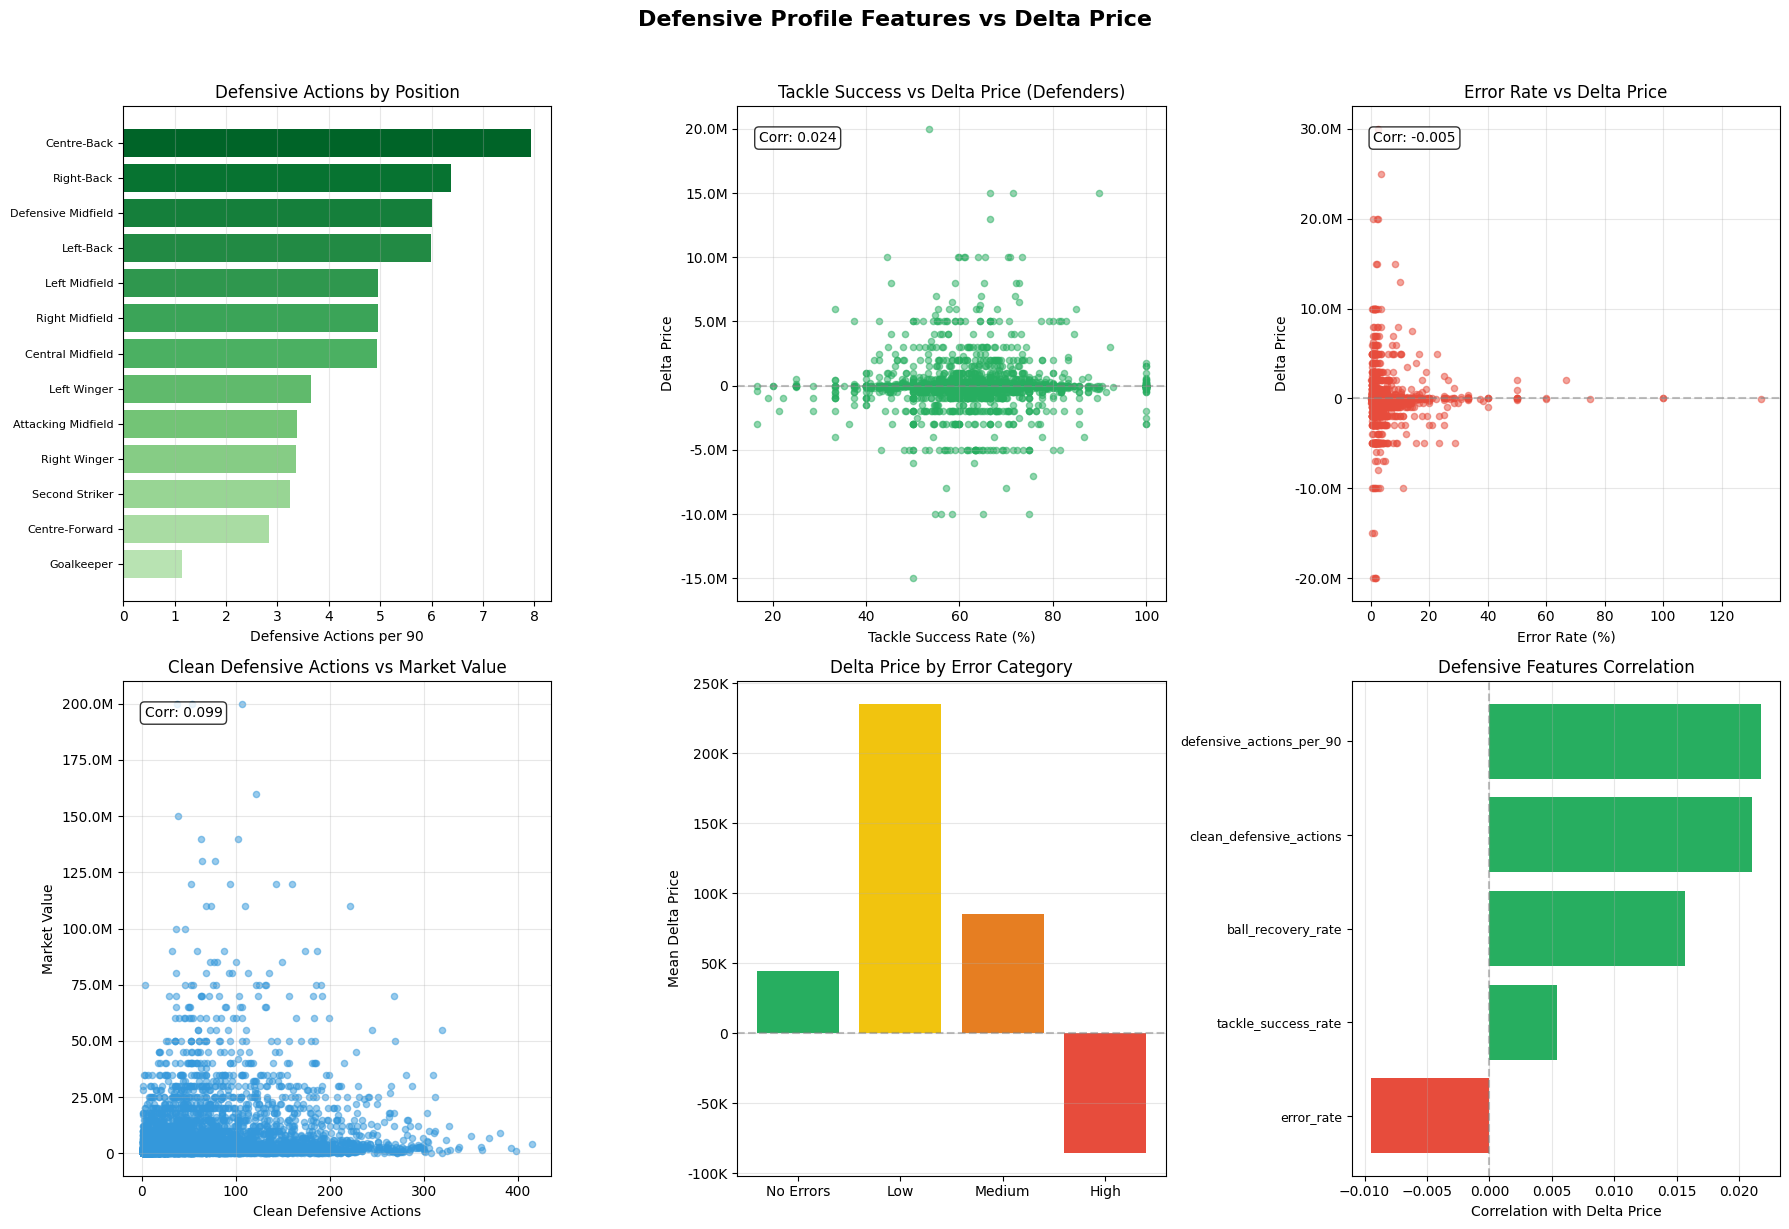


Defensive Profile Insights

📊 Correlations with Delta Price:
   tackle_success_rate: 0.0054
   defensive_actions_per_90: 0.0217
   error_rate: -0.0095
   clean_defensive_actions: 0.0210
   ball_recovery_rate: 0.0156

📊 Correlations with Market Value:
   tackle_success_rate: 0.0523
   defensive_actions_per_90: -0.0426
   error_rate: 0.0073
   clean_defensive_actions: 0.1085
   ball_recovery_rate: -0.0292


In [ ]:
defensive_feats = [
    'tackle_success_rate', 'defensive_actions_per_90', 'error_rate', 
    'clean_defensive_actions', 'ball_recovery_rate'
]

def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    return f'{x:.0f}'

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Defensive Profile Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

defensive_positions = ['Centre-Back', 'Right-Back', 'Left-Back', 'Defensive Midfield']
df_def = df[df['position'].isin(defensive_positions)].copy()

ax1 = axes[0, 0]
pos_def_actions = df.groupby('position')['defensive_actions_per_90'].mean().sort_values(ascending=True)
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(pos_def_actions)))
ax1.barh(range(len(pos_def_actions)), pos_def_actions.values, color=colors)
ax1.set_yticks(range(len(pos_def_actions)))
ax1.set_yticklabels(pos_def_actions.index, fontsize=8)
ax1.set_xlabel('Defensive Actions per 90')
ax1.set_title('Defensive Actions by Position')
ax1.grid(axis='x', alpha=0.3)

ax2 = axes[0, 1]
plot_df = df_def[['tackle_success_rate', 'delta_price']].dropna()
plot_df = plot_df[plot_df['tackle_success_rate'] > 0]
ax2.scatter(plot_df['tackle_success_rate'], plot_df['delta_price'], alpha=0.5, c='#27ae60', s=20)
ax2.set_xlabel('Tackle Success Rate (%)')
ax2.set_ylabel('Delta Price')
ax2.set_title('Tackle Success vs Delta Price (Defenders)')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['tackle_success_rate'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['error_rate', 'delta_price']].dropna()
plot_df = plot_df[plot_df['error_rate'] > 0]
ax3.scatter(plot_df['error_rate'], plot_df['delta_price'], alpha=0.5, c='#e74c3c', s=20)
ax3.set_xlabel('Error Rate (%)')
ax3.set_ylabel('Delta Price')
ax3.set_title('Error Rate vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['error_rate'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
plot_df = df[['clean_defensive_actions', 'MarketValueCurrent']].dropna()
plot_df = plot_df[plot_df['clean_defensive_actions'] > 0]
ax4.scatter(plot_df['clean_defensive_actions'], plot_df['MarketValueCurrent'], alpha=0.5, c='#3498db', s=20)
ax4.set_xlabel('Clean Defensive Actions')
ax4.set_ylabel('Market Value')
ax4.set_title('Clean Defensive Actions vs Market Value')
ax4.yaxis.set_major_formatter(FuncFormatter(format_price))
ax4.grid(alpha=0.3)
corr = plot_df['clean_defensive_actions'].corr(plot_df['MarketValueCurrent'])
ax4.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax4.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax5 = axes[1, 1]
error_bins = pd.cut(df['error_rate'], bins=[-np.inf, 0, 0.5, 1, np.inf], labels=['No Errors', 'Low', 'Medium', 'High'])
error_delta = df.groupby(error_bins, observed=True)['delta_price'].mean()
colors = ['#27ae60', '#f1c40f', '#e67e22', '#e74c3c']
bars = ax5.bar(range(len(error_delta)), error_delta.values, color=colors[:len(error_delta)])
ax5.set_xticks(range(len(error_delta)))
ax5.set_xticklabels(error_delta.index)
ax5.set_ylabel('Mean Delta Price')
ax5.set_title('Delta Price by Error Category')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

ax6 = axes[1, 2]
corr_data = df[defensive_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Defensive Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Defensive Profile Insights")
print(f"{'='*70}")
print(f"\n📊 Correlations with Delta Price:")
for feat in defensive_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n📊 Correlations with Market Value:")
for feat in defensive_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.2 Attacking Contribution Analysis

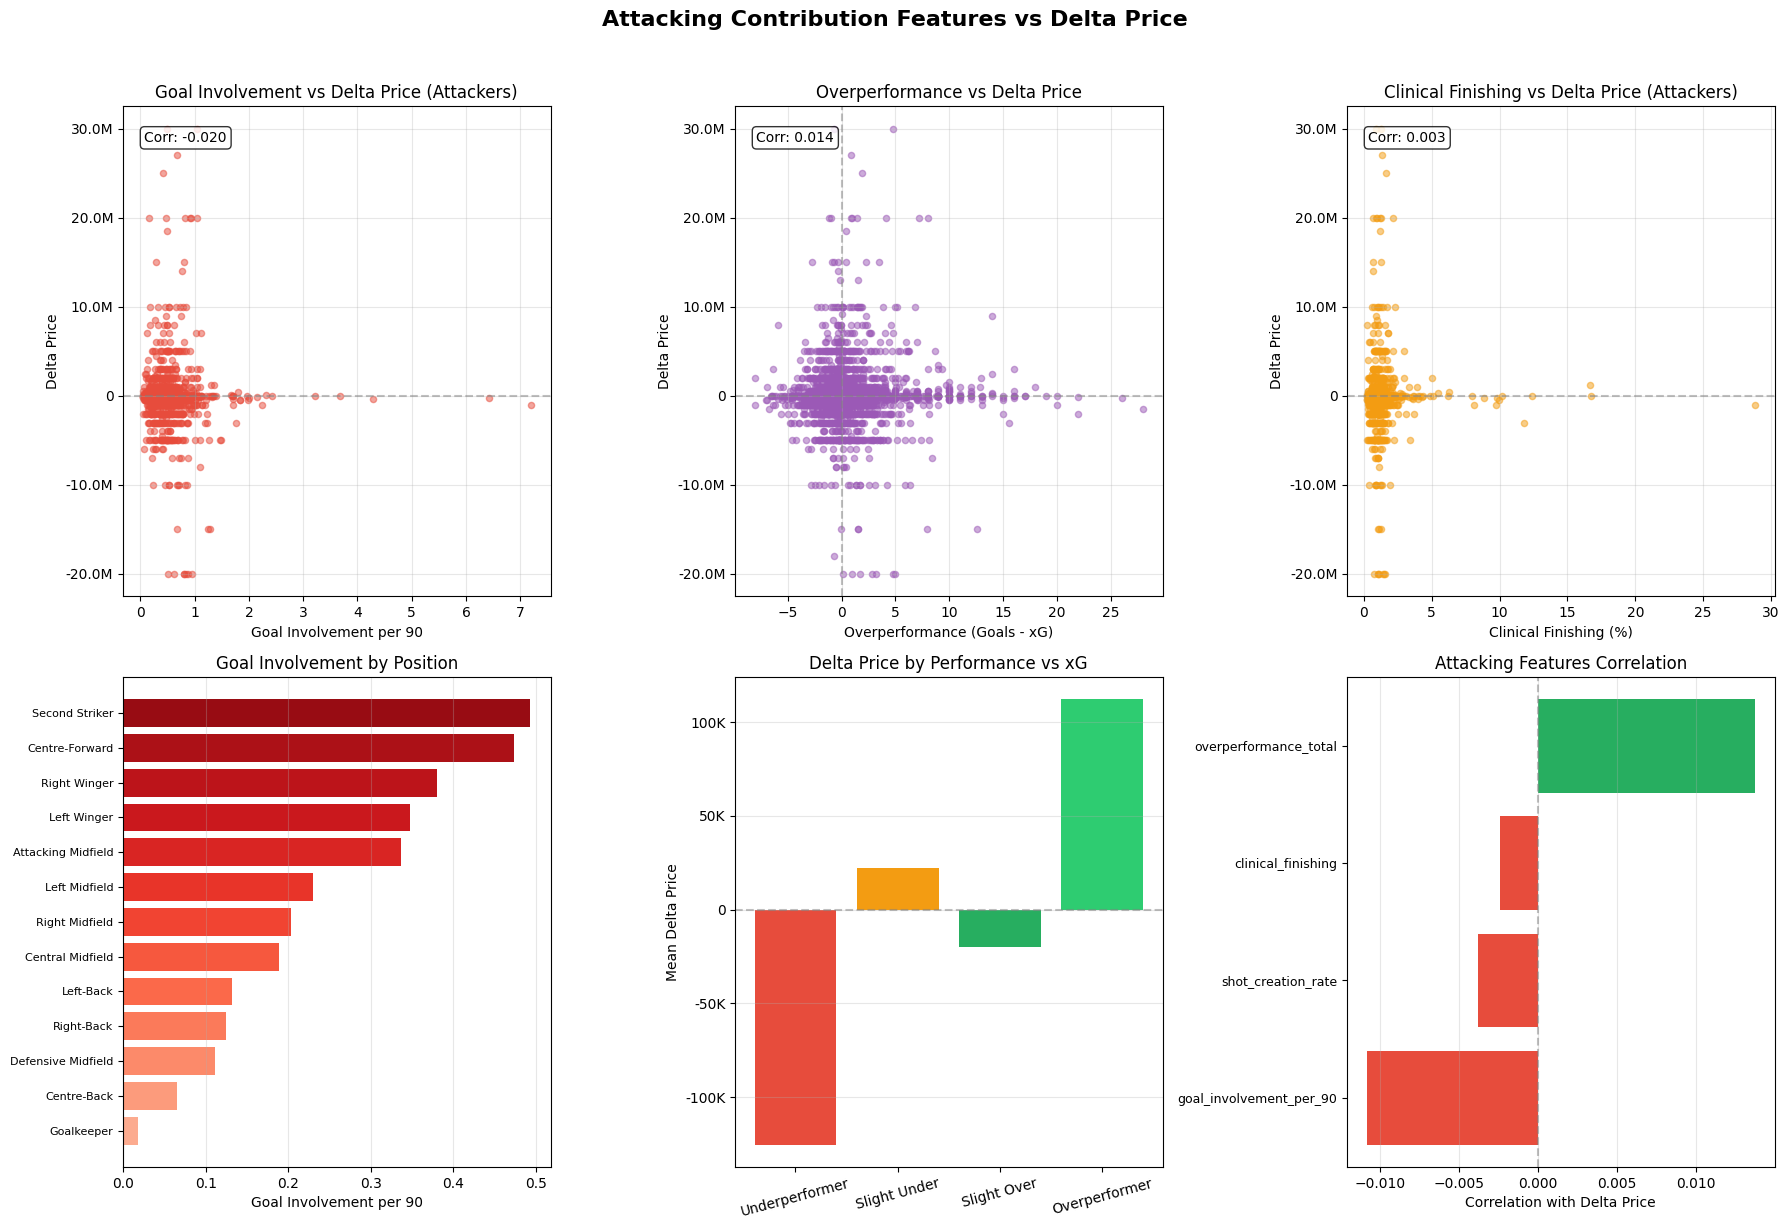


Attacking Contribution Insights

📊 Correlations with Delta Price:
   goal_involvement_per_90: -0.0109
   overperformance_total: 0.0137
   shot_creation_rate: -0.0038
   clinical_finishing: -0.0024

📊 Correlations with Market Value:
   goal_involvement_per_90: 0.1884
   overperformance_total: 0.0422
   shot_creation_rate: 0.1503
   clinical_finishing: 0.0808


In [ ]:
attacking_feats = [
    'goal_involvement_per_90', 'overperformance_total', 'shot_creation_rate', 'clinical_finishing'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Attacking Contribution Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

attacking_positions = ['Centre-Forward', 'Second Striker', 'Right Winger', 'Left Winger', 'Attacking Midfield']
df_att = df[df['position'].isin(attacking_positions)].copy()

ax1 = axes[0, 0]
plot_df = df_att[['goal_involvement_per_90', 'delta_price']].dropna()
plot_df = plot_df[plot_df['goal_involvement_per_90'] > 0]
ax1.scatter(plot_df['goal_involvement_per_90'], plot_df['delta_price'], alpha=0.5, c='#e74c3c', s=20)
ax1.set_xlabel('Goal Involvement per 90')
ax1.set_ylabel('Delta Price')
ax1.set_title('Goal Involvement vs Delta Price (Attackers)')
ax1.yaxis.set_major_formatter(FuncFormatter(format_price))
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3)
corr = plot_df['goal_involvement_per_90'].corr(plot_df['delta_price'])
ax1.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2 = axes[0, 1]
plot_df = df[['overperformance_total', 'delta_price']].dropna()
ax2.scatter(plot_df['overperformance_total'], plot_df['delta_price'], alpha=0.5, c='#9b59b6', s=20)
ax2.set_xlabel('Overperformance (Goals - xG)')
ax2.set_ylabel('Delta Price')
ax2.set_title('Overperformance vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['overperformance_total'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df_att[['clinical_finishing', 'delta_price']].dropna()
plot_df = plot_df[plot_df['clinical_finishing'] > 0]
ax3.scatter(plot_df['clinical_finishing'], plot_df['delta_price'], alpha=0.5, c='#f39c12', s=20)
ax3.set_xlabel('Clinical Finishing (%)')
ax3.set_ylabel('Delta Price')
ax3.set_title('Clinical Finishing vs Delta Price (Attackers)')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['clinical_finishing'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
pos_goal_inv = df.groupby('position')['goal_involvement_per_90'].mean().sort_values(ascending=True)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(pos_goal_inv)))
ax4.barh(range(len(pos_goal_inv)), pos_goal_inv.values, color=colors)
ax4.set_yticks(range(len(pos_goal_inv)))
ax4.set_yticklabels(pos_goal_inv.index, fontsize=8)
ax4.set_xlabel('Goal Involvement per 90')
ax4.set_title('Goal Involvement by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
overperf_bins = pd.cut(df['overperformance_total'], bins=[-np.inf, -3, 0, 3, np.inf], 
                        labels=['Underperformer', 'Slight Under', 'Slight Over', 'Overperformer'])
overperf_delta = df.groupby(overperf_bins, observed=True)['delta_price'].mean()
colors = ['#e74c3c', '#f39c12', '#27ae60', '#2ecc71']
bars = ax5.bar(range(len(overperf_delta)), overperf_delta.values, color=colors[:len(overperf_delta)])
ax5.set_xticks(range(len(overperf_delta)))
ax5.set_xticklabels(overperf_delta.index, rotation=15)
ax5.set_ylabel('Mean Delta Price')
ax5.set_title('Delta Price by Performance vs xG')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

ax6 = axes[1, 2]
corr_data = df[attacking_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Attacking Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Attacking Contribution Insights")
print(f"{'='*70}")
print(f"\n📊 Correlations with Delta Price:")
for feat in attacking_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n📊 Correlations with Market Value:")
for feat in attacking_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.3 Ball Progression Analysis

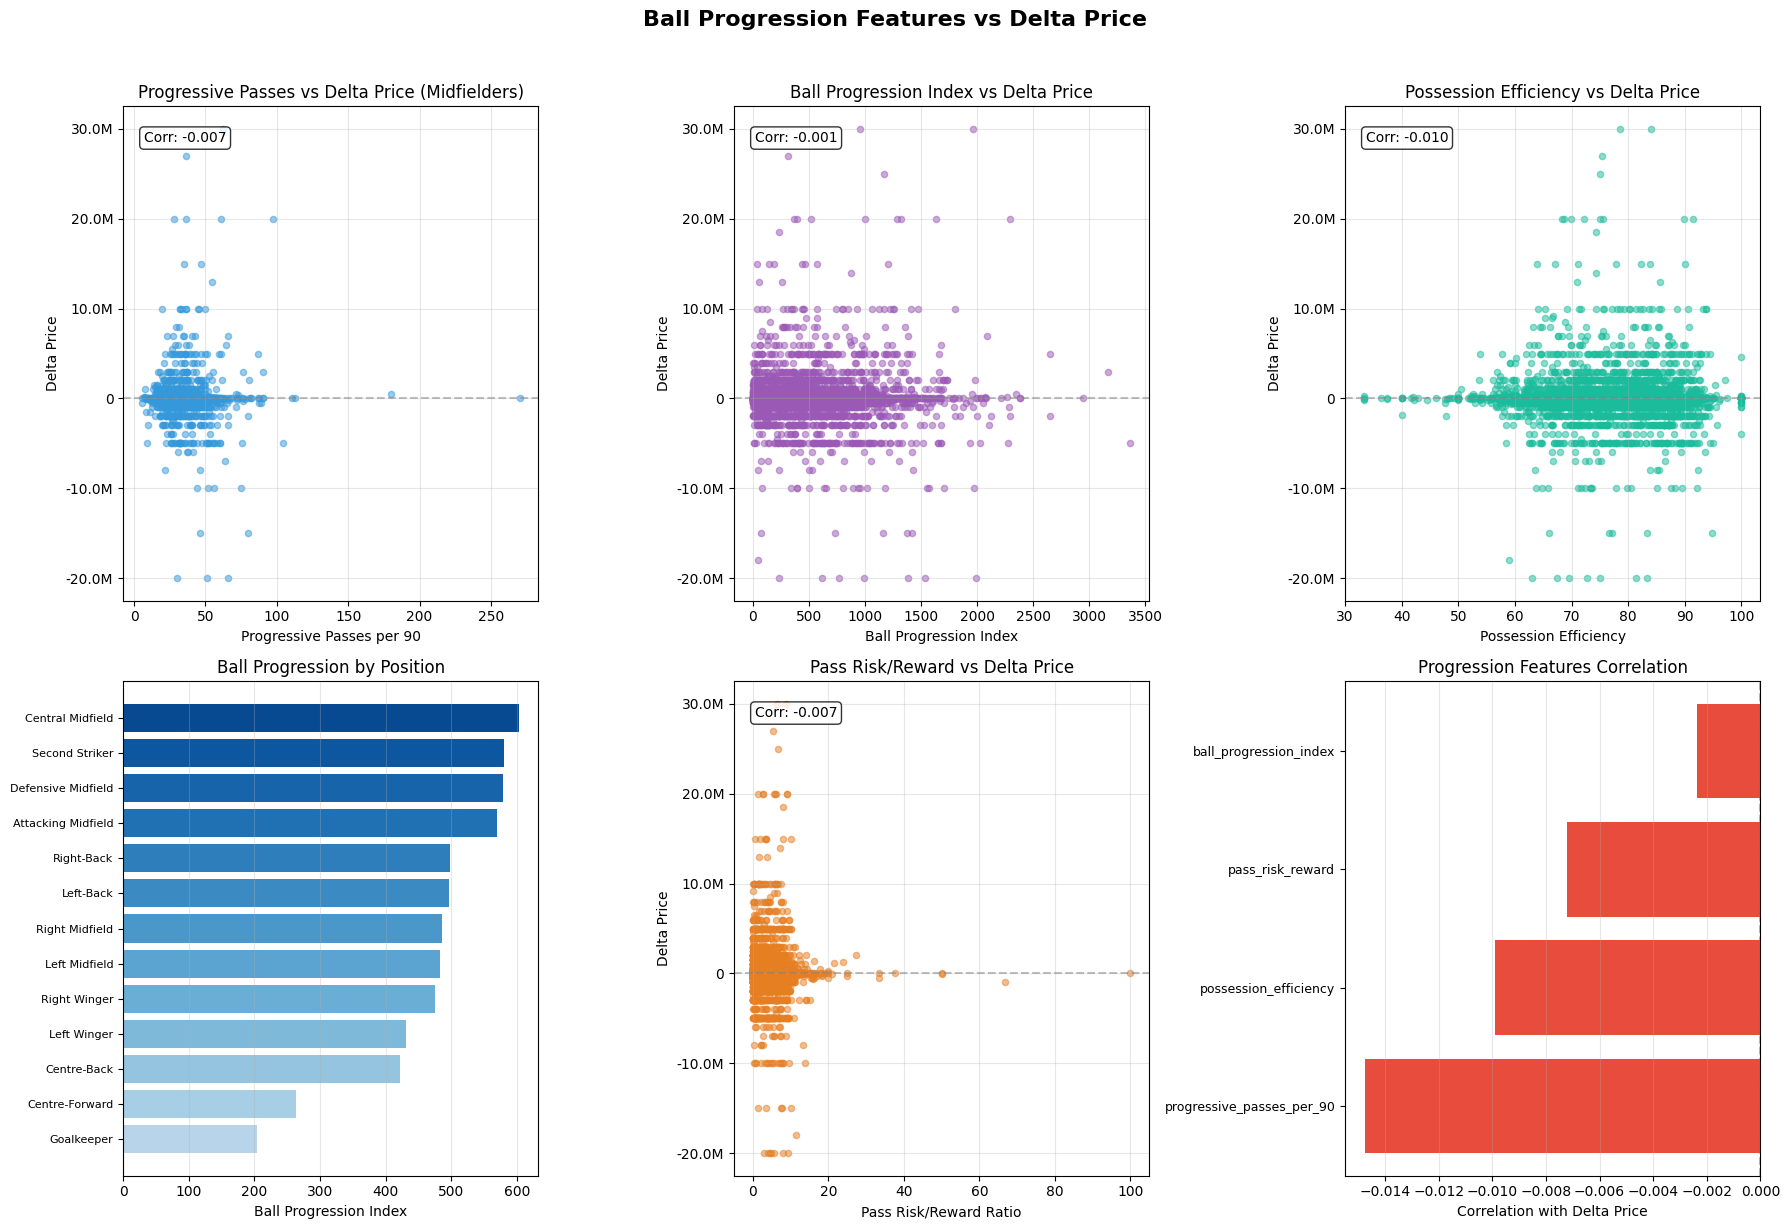


Ball Progression Insights

📊 Correlations with Delta Price:
   progressive_passes_per_90: -0.0148
   ball_progression_index: -0.0024
   possession_efficiency: -0.0099
   pass_risk_reward: -0.0072

📊 Correlations with Market Value:
   progressive_passes_per_90: 0.2076
   ball_progression_index: 0.3735
   possession_efficiency: 0.0848
   pass_risk_reward: 0.0915


In [ ]:
progression_feats = [
    'progressive_passes_per_90', 'ball_progression_index', 'possession_efficiency', 'pass_risk_reward'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Ball Progression Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

midfield_positions = ['Central Midfield', 'Attacking Midfield', 'Defensive Midfield', 'Left Midfield', 'Right Midfield']
df_mid = df[df['position'].isin(midfield_positions)].copy()

ax1 = axes[0, 0]
plot_df = df_mid[['progressive_passes_per_90', 'delta_price']].dropna()
plot_df = plot_df[plot_df['progressive_passes_per_90'] > 0]
ax1.scatter(plot_df['progressive_passes_per_90'], plot_df['delta_price'], alpha=0.5, c='#3498db', s=20)
ax1.set_xlabel('Progressive Passes per 90')
ax1.set_ylabel('Delta Price')
ax1.set_title('Progressive Passes vs Delta Price (Midfielders)')
ax1.yaxis.set_major_formatter(FuncFormatter(format_price))
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3)
corr = plot_df['progressive_passes_per_90'].corr(plot_df['delta_price'])
ax1.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2 = axes[0, 1]
plot_df = df[['ball_progression_index', 'delta_price']].dropna()
plot_df = plot_df[plot_df['ball_progression_index'] > 0]
ax2.scatter(plot_df['ball_progression_index'], plot_df['delta_price'], alpha=0.5, c='#9b59b6', s=20)
ax2.set_xlabel('Ball Progression Index')
ax2.set_ylabel('Delta Price')
ax2.set_title('Ball Progression Index vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['ball_progression_index'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['possession_efficiency', 'delta_price']].dropna()
plot_df = plot_df[plot_df['possession_efficiency'] > 0]
ax3.scatter(plot_df['possession_efficiency'], plot_df['delta_price'], alpha=0.5, c='#1abc9c', s=20)
ax3.set_xlabel('Possession Efficiency')
ax3.set_ylabel('Delta Price')
ax3.set_title('Possession Efficiency vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['possession_efficiency'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
pos_prog = df.groupby('position')['ball_progression_index'].mean().sort_values(ascending=True)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(pos_prog)))
ax4.barh(range(len(pos_prog)), pos_prog.values, color=colors)
ax4.set_yticks(range(len(pos_prog)))
ax4.set_yticklabels(pos_prog.index, fontsize=8)
ax4.set_xlabel('Ball Progression Index')
ax4.set_title('Ball Progression by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
plot_df = df[['pass_risk_reward', 'delta_price']].dropna()
ax5.scatter(plot_df['pass_risk_reward'], plot_df['delta_price'], alpha=0.5, c='#e67e22', s=20)
ax5.set_xlabel('Pass Risk/Reward Ratio')
ax5.set_ylabel('Delta Price')
ax5.set_title('Pass Risk/Reward vs Delta Price')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(alpha=0.3)
corr = plot_df['pass_risk_reward'].corr(plot_df['delta_price'])
ax5.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax5.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6 = axes[1, 2]
corr_data = df[progression_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Progression Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Ball Progression Insights")
print(f"{'='*70}")
print(f"\n📊 Correlations with Delta Price:")
for feat in progression_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n📊 Correlations with Market Value:")
for feat in progression_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.4 Physical Dominance Analysis

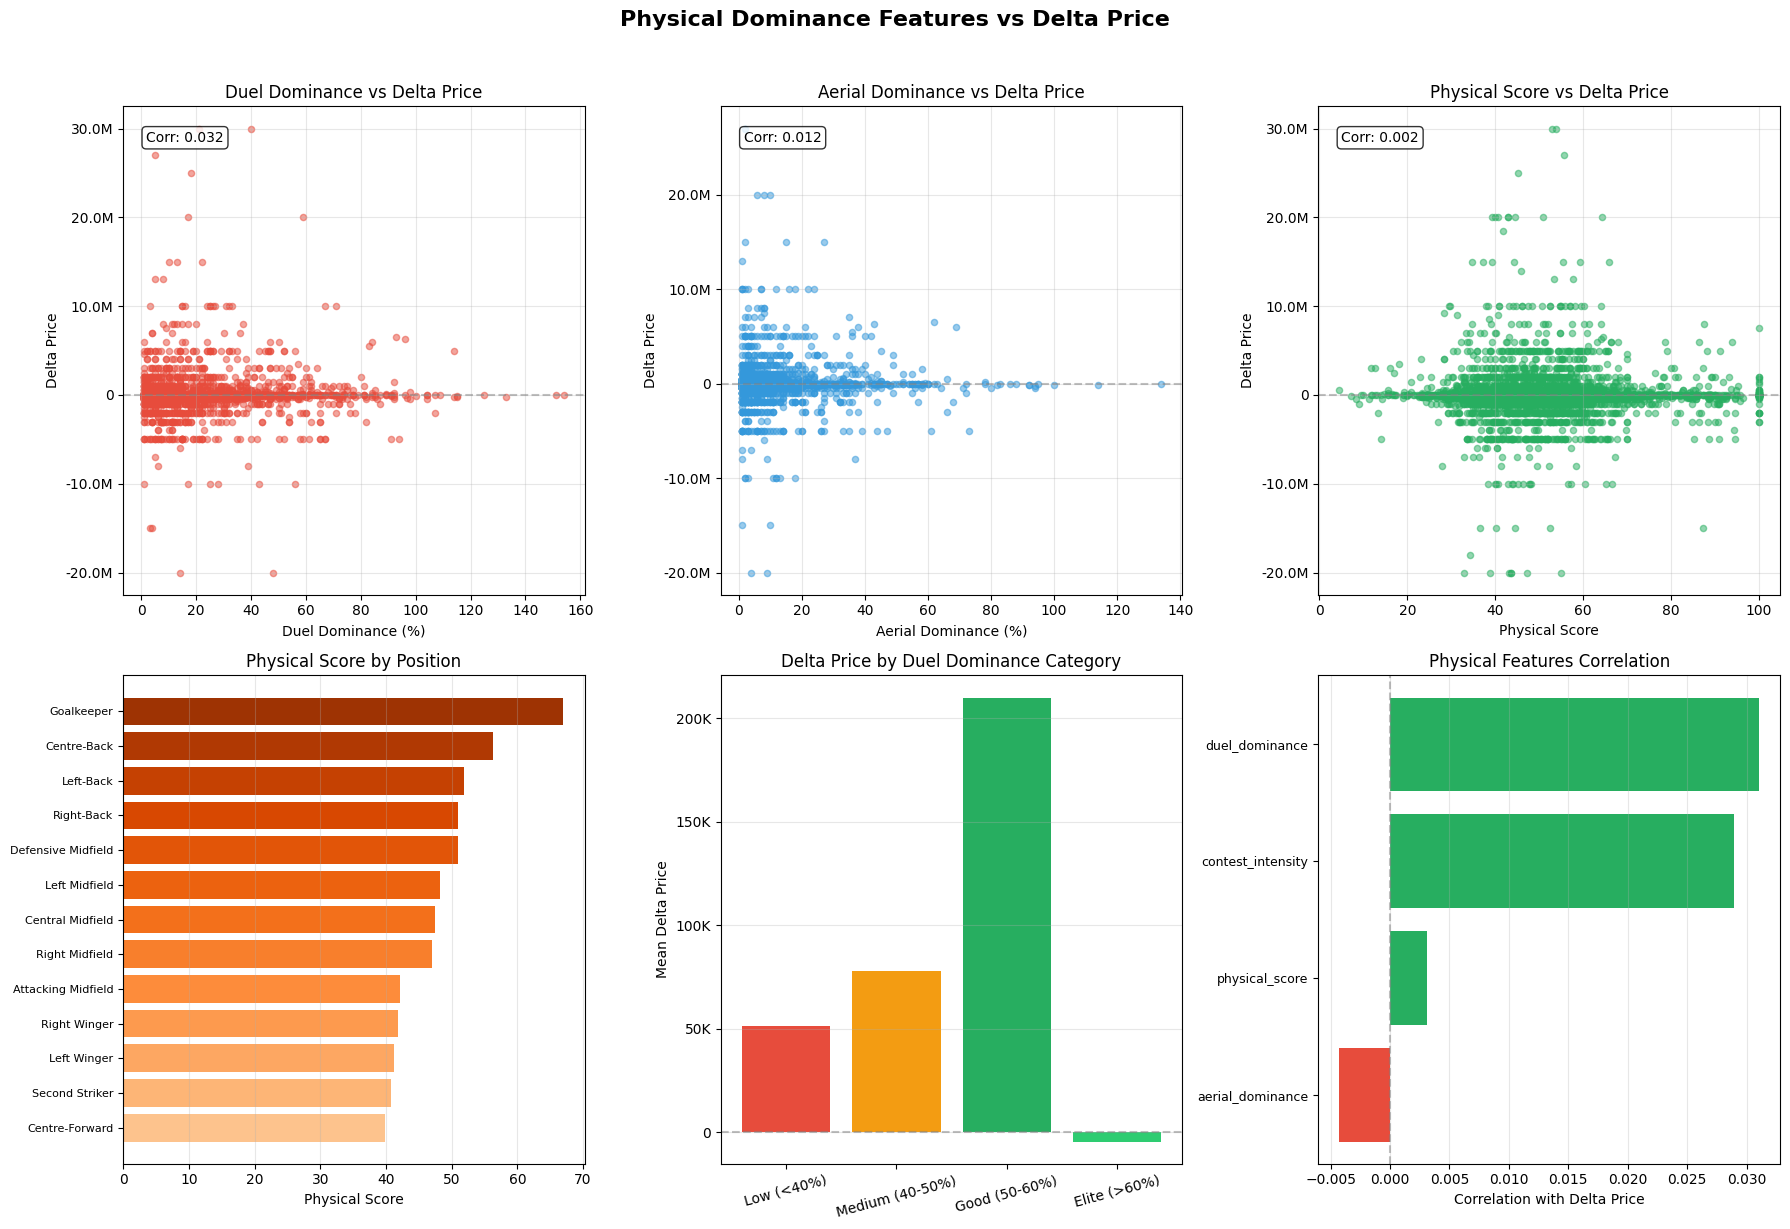


Physical Dominance Insights

📊 Correlations with Delta Price:
   duel_dominance: 0.0310
   aerial_dominance: -0.0043
   physical_score: 0.0031
   contest_intensity: 0.0290

📊 Correlations with Market Value:
   duel_dominance: -0.0107
   aerial_dominance: -0.0180
   physical_score: 0.0210
   contest_intensity: 0.0973


In [ ]:
physical_feats = [
    'duel_dominance', 'aerial_dominance', 'physical_score', 'contest_intensity'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Physical Dominance Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
plot_df = df[['duel_dominance', 'delta_price']].dropna()
plot_df = plot_df[plot_df['duel_dominance'] > 0]
ax1.scatter(plot_df['duel_dominance'], plot_df['delta_price'], alpha=0.5, c='#e74c3c', s=20)
ax1.set_xlabel('Duel Dominance (%)')
ax1.set_ylabel('Delta Price')
ax1.set_title('Duel Dominance vs Delta Price')
ax1.yaxis.set_major_formatter(FuncFormatter(format_price))
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3)
corr = plot_df['duel_dominance'].corr(plot_df['delta_price'])
ax1.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2 = axes[0, 1]
plot_df = df[['aerial_dominance', 'delta_price']].dropna()
plot_df = plot_df[plot_df['aerial_dominance'] > 0]
ax2.scatter(plot_df['aerial_dominance'], plot_df['delta_price'], alpha=0.5, c='#3498db', s=20)
ax2.set_xlabel('Aerial Dominance (%)')
ax2.set_ylabel('Delta Price')
ax2.set_title('Aerial Dominance vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['aerial_dominance'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['physical_score', 'delta_price']].dropna()
plot_df = plot_df[plot_df['physical_score'] > 0]
ax3.scatter(plot_df['physical_score'], plot_df['delta_price'], alpha=0.5, c='#27ae60', s=20)
ax3.set_xlabel('Physical Score')
ax3.set_ylabel('Delta Price')
ax3.set_title('Physical Score vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['physical_score'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
pos_phys = df.groupby('position')['physical_score'].mean().sort_values(ascending=True)
colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(pos_phys)))
ax4.barh(range(len(pos_phys)), pos_phys.values, color=colors)
ax4.set_yticks(range(len(pos_phys)))
ax4.set_yticklabels(pos_phys.index, fontsize=8)
ax4.set_xlabel('Physical Score')
ax4.set_title('Physical Score by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
duel_bins = pd.cut(df['duel_dominance'], bins=[0, 40, 50, 60, 100], labels=['Low (<40%)', 'Medium (40-50%)', 'Good (50-60%)', 'Elite (>60%)'])
duel_delta = df.groupby(duel_bins, observed=True)['delta_price'].mean()
colors = ['#e74c3c', '#f39c12', '#27ae60', '#2ecc71']
bars = ax5.bar(range(len(duel_delta)), duel_delta.values, color=colors[:len(duel_delta)])
ax5.set_xticks(range(len(duel_delta)))
ax5.set_xticklabels(duel_delta.index, rotation=15)
ax5.set_ylabel('Mean Delta Price')
ax5.set_title('Delta Price by Duel Dominance Category')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

ax6 = axes[1, 2]
corr_data = df[physical_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Physical Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Physical Dominance Insights")
print(f"{'='*70}")
print(f"\n📊 Correlations with Delta Price:")
for feat in physical_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n📊 Correlations with Market Value:")
for feat in physical_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.5 Risk Profile Analysis

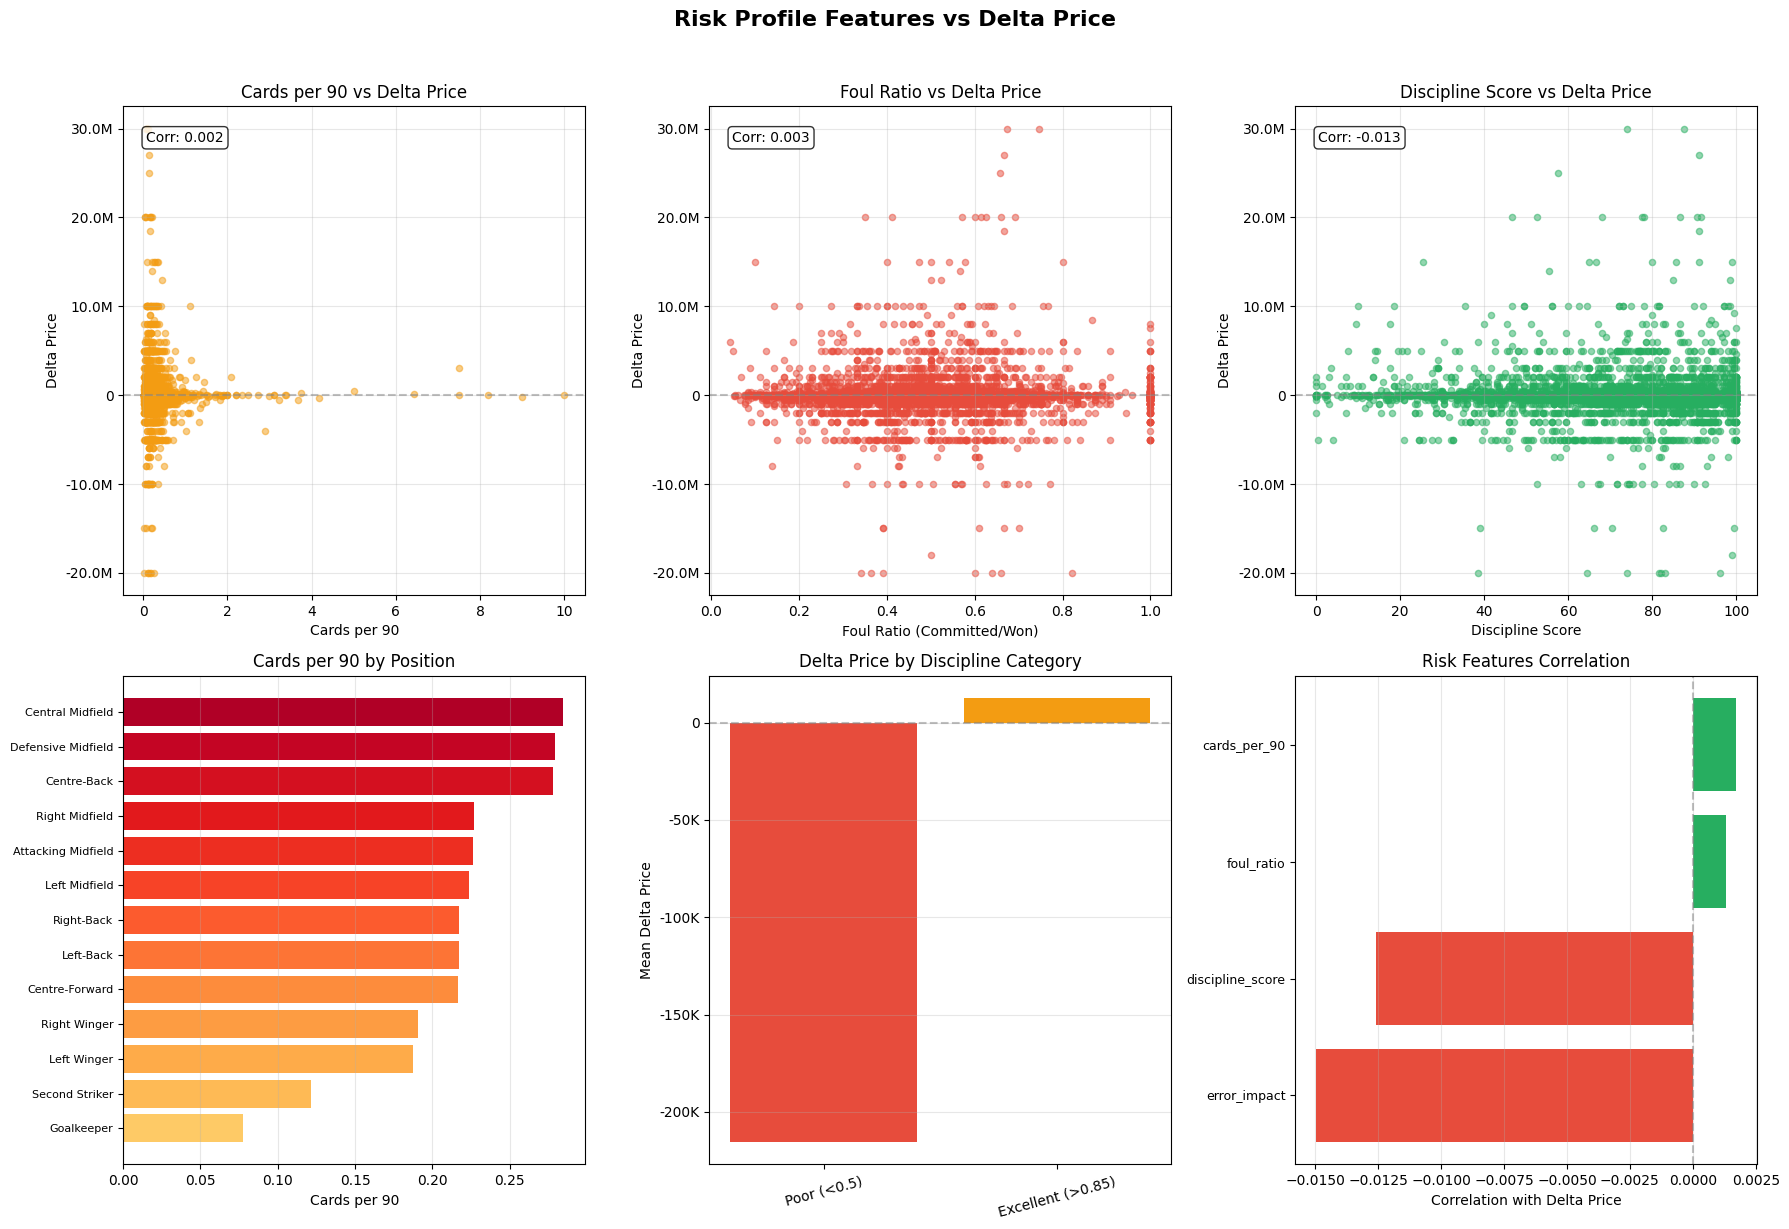


Risk Profile Insights

📊 Correlations with Delta Price:
   cards_per_90: 0.0017
   foul_ratio: 0.0013
   error_impact: -0.0150
   discipline_score: -0.0126

📊 Correlations with Market Value:
   cards_per_90: -0.0483
   foul_ratio: 0.0658
   error_impact: 0.1000
   discipline_score: -0.1355


In [ ]:
risk_feats = [
    'cards_per_90', 'foul_ratio', 'error_impact', 'discipline_score'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Risk Profile Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
plot_df = df[['cards_per_90', 'delta_price']].dropna()
plot_df = plot_df[plot_df['cards_per_90'] > 0]
ax1.scatter(plot_df['cards_per_90'], plot_df['delta_price'], alpha=0.5, c='#f39c12', s=20)
ax1.set_xlabel('Cards per 90')
ax1.set_ylabel('Delta Price')
ax1.set_title('Cards per 90 vs Delta Price')
ax1.yaxis.set_major_formatter(FuncFormatter(format_price))
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3)
corr = plot_df['cards_per_90'].corr(plot_df['delta_price'])
ax1.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2 = axes[0, 1]
plot_df = df[['foul_ratio', 'delta_price']].dropna()
plot_df = plot_df[plot_df['foul_ratio'] > 0]
ax2.scatter(plot_df['foul_ratio'], plot_df['delta_price'], alpha=0.5, c='#e74c3c', s=20)
ax2.set_xlabel('Foul Ratio (Committed/Won)')
ax2.set_ylabel('Delta Price')
ax2.set_title('Foul Ratio vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['foul_ratio'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['discipline_score', 'delta_price']].dropna()
ax3.scatter(plot_df['discipline_score'], plot_df['delta_price'], alpha=0.5, c='#27ae60', s=20)
ax3.set_xlabel('Discipline Score')
ax3.set_ylabel('Delta Price')
ax3.set_title('Discipline Score vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['discipline_score'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
pos_cards = df.groupby('position')['cards_per_90'].mean().sort_values(ascending=True)
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(pos_cards)))
ax4.barh(range(len(pos_cards)), pos_cards.values, color=colors)
ax4.set_yticks(range(len(pos_cards)))
ax4.set_yticklabels(pos_cards.index, fontsize=8)
ax4.set_xlabel('Cards per 90')
ax4.set_title('Cards per 90 by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
discipline_bins = pd.cut(df['discipline_score'], bins=[-np.inf, 0.5, 0.7, 0.85, np.inf], 
                          labels=['Poor (<0.5)', 'Average (0.5-0.7)', 'Good (0.7-0.85)', 'Excellent (>0.85)'])
disc_delta = df.groupby(discipline_bins, observed=True)['delta_price'].mean()
colors = ['#e74c3c', '#f39c12', '#27ae60', '#2ecc71']
bars = ax5.bar(range(len(disc_delta)), disc_delta.values, color=colors[:len(disc_delta)])
ax5.set_xticks(range(len(disc_delta)))
ax5.set_xticklabels(disc_delta.index, rotation=15)
ax5.set_ylabel('Mean Delta Price')
ax5.set_title('Delta Price by Discipline Category')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

ax6 = axes[1, 2]
corr_data = df[risk_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Risk Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Risk Profile Insights")
print(f"{'='*70}")
print(f"\n Correlations with Delta Price:")
for feat in risk_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n Correlations with Market Value:")
for feat in risk_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.6 Set Piece Specialist Analysis

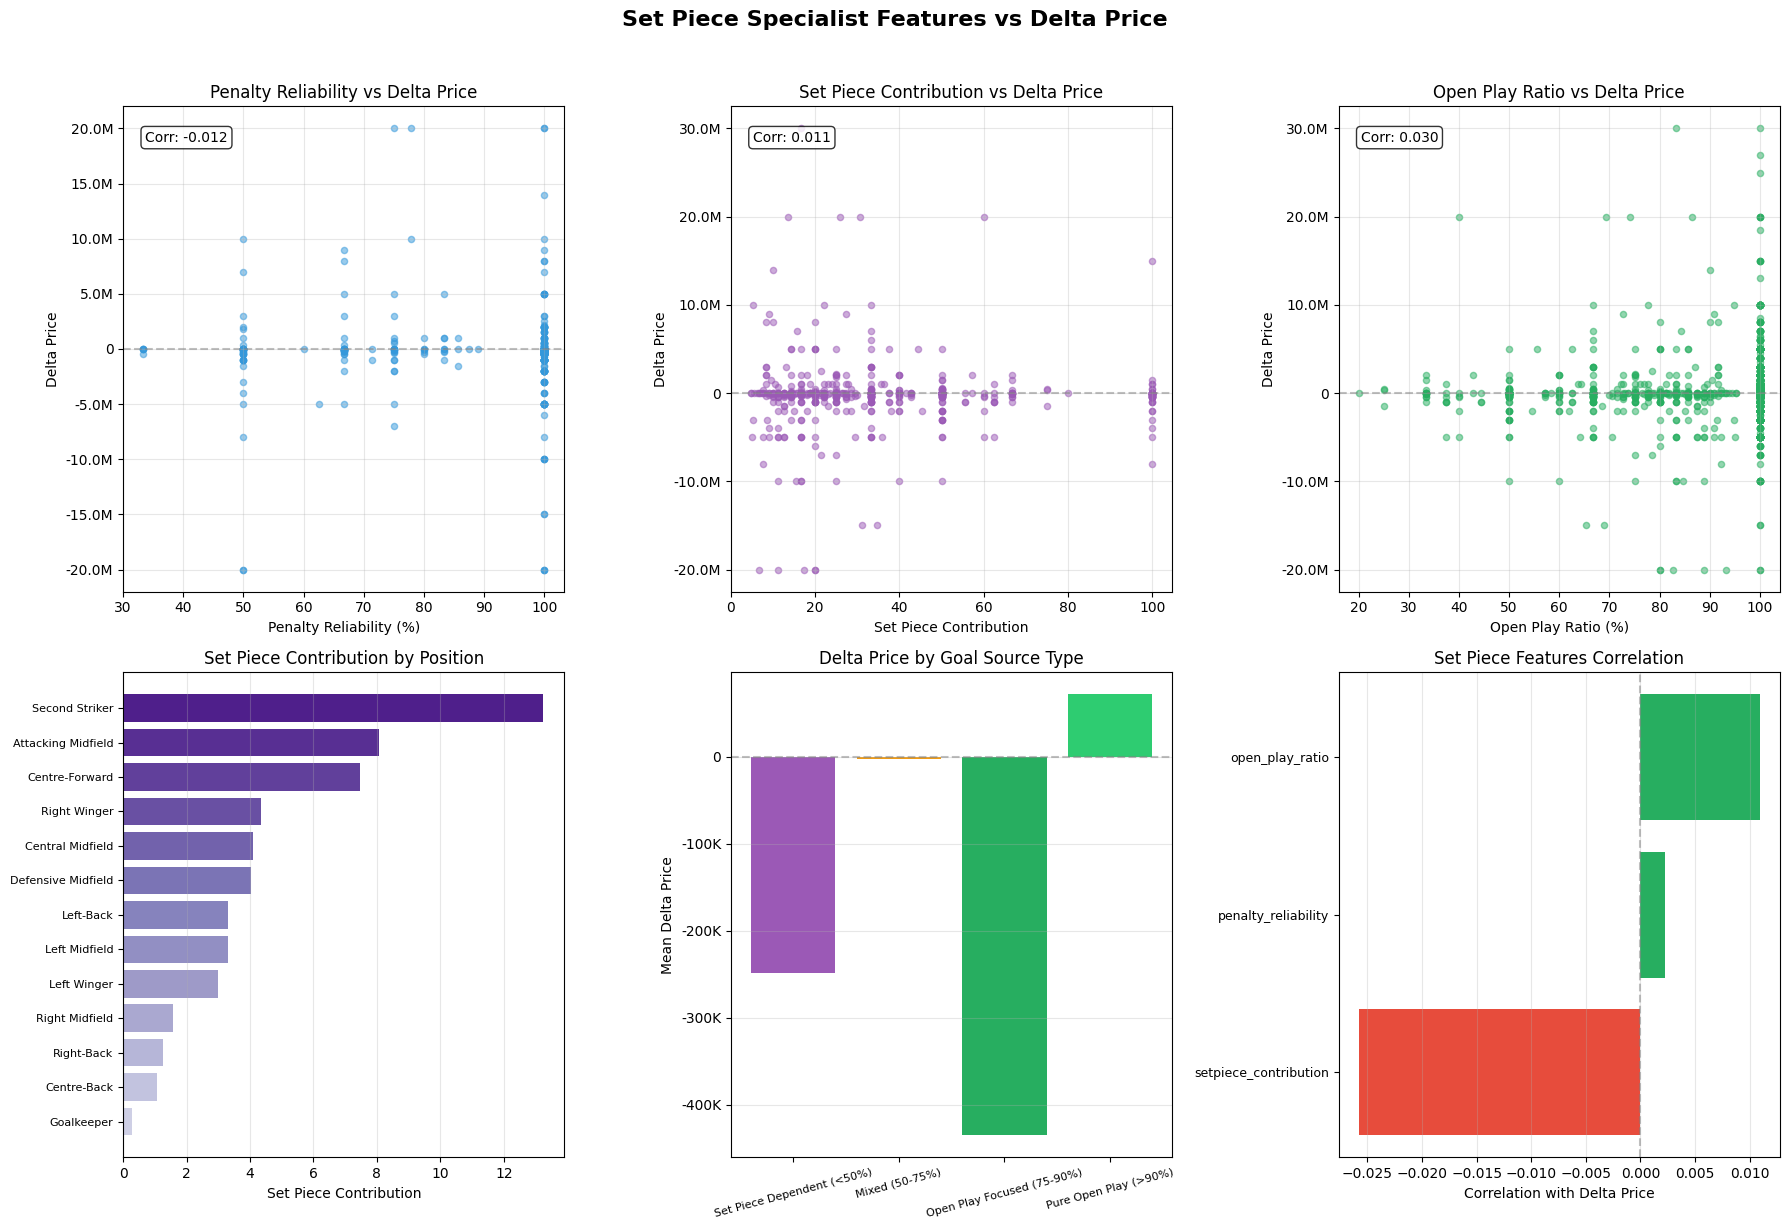


Set Piece Specialist Insights

📊 Correlations with Delta Price:
   penalty_reliability: 0.0023
   setpiece_contribution: -0.0258
   open_play_ratio: 0.0110

📊 Correlations with Market Value:
   penalty_reliability: 0.0299
   setpiece_contribution: 0.0556
   open_play_ratio: 0.1743


In [ ]:
setpiece_feats = [
    'penalty_reliability', 'setpiece_contribution', 'open_play_ratio'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Set Piece Specialist Features vs Delta Price', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
plot_df = df[['penalty_reliability', 'delta_price']].dropna()
plot_df = plot_df[plot_df['penalty_reliability'] > 0]
ax1.scatter(plot_df['penalty_reliability'], plot_df['delta_price'], alpha=0.5, c='#3498db', s=20)
ax1.set_xlabel('Penalty Reliability (%)')
ax1.set_ylabel('Delta Price')
ax1.set_title('Penalty Reliability vs Delta Price')
ax1.yaxis.set_major_formatter(FuncFormatter(format_price))
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3)
corr = plot_df['penalty_reliability'].corr(plot_df['delta_price'])
ax1.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2 = axes[0, 1]
plot_df = df[['setpiece_contribution', 'delta_price']].dropna()
plot_df = plot_df[plot_df['setpiece_contribution'] > 0]
ax2.scatter(plot_df['setpiece_contribution'], plot_df['delta_price'], alpha=0.5, c='#9b59b6', s=20)
ax2.set_xlabel('Set Piece Contribution')
ax2.set_ylabel('Delta Price')
ax2.set_title('Set Piece Contribution vs Delta Price')
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)
corr = plot_df['setpiece_contribution'].corr(plot_df['delta_price'])
ax2.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3 = axes[0, 2]
plot_df = df[['open_play_ratio', 'delta_price']].dropna()
plot_df = plot_df[plot_df['open_play_ratio'] > 0]
ax3.scatter(plot_df['open_play_ratio'], plot_df['delta_price'], alpha=0.5, c='#27ae60', s=20)
ax3.set_xlabel('Open Play Ratio (%)')
ax3.set_ylabel('Delta Price')
ax3.set_title('Open Play Ratio vs Delta Price')
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.grid(alpha=0.3)
corr = plot_df['open_play_ratio'].corr(plot_df['delta_price'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4 = axes[1, 0]
pos_setpiece = df.groupby('position')['setpiece_contribution'].mean().sort_values(ascending=True)
colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(pos_setpiece)))
ax4.barh(range(len(pos_setpiece)), pos_setpiece.values, color=colors)
ax4.set_yticks(range(len(pos_setpiece)))
ax4.set_yticklabels(pos_setpiece.index, fontsize=8)
ax4.set_xlabel('Set Piece Contribution')
ax4.set_title('Set Piece Contribution by Position')
ax4.grid(axis='x', alpha=0.3)

ax5 = axes[1, 1]
open_play_bins = pd.cut(df['open_play_ratio'], bins=[0, 50, 75, 90, 100], 
                         labels=['Set Piece Dependent (<50%)', 'Mixed (50-75%)', 'Open Play Focused (75-90%)', 'Pure Open Play (>90%)'])
open_delta = df.groupby(open_play_bins, observed=True)['delta_price'].mean()
colors = ['#9b59b6', '#f39c12', '#27ae60', '#2ecc71']
bars = ax5.bar(range(len(open_delta)), open_delta.values, color=colors[:len(open_delta)])
ax5.set_xticks(range(len(open_delta)))
ax5.set_xticklabels(open_delta.index, rotation=15, fontsize=8)
ax5.set_ylabel('Mean Delta Price')
ax5.set_title('Delta Price by Goal Source Type')
ax5.yaxis.set_major_formatter(FuncFormatter(format_price))
ax5.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

ax6 = axes[1, 2]
corr_data = df[setpiece_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_data.values]
ax6.barh(range(len(corr_data)), corr_data.values, color=colors)
ax6.set_yticks(range(len(corr_data)))
ax6.set_yticklabels(corr_data.index, fontsize=9)
ax6.set_xlabel('Correlation with Delta Price')
ax6.set_title('Set Piece Features Correlation')
ax6.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"Set Piece Specialist Insights")
print(f"{'='*70}")
print(f"\n Correlations with Delta Price:")
for feat in setpiece_feats:
    corr = df[feat].corr(df['delta_price'])
    print(f"   {feat}: {corr:.4f}")
print(f"\n Correlations with Market Value:")
for feat in setpiece_feats:
    corr = df[feat].corr(df['MarketValueCurrent'])
    print(f"   {feat}: {corr:.4f}")

## 8.7 Feature Engineering Summary

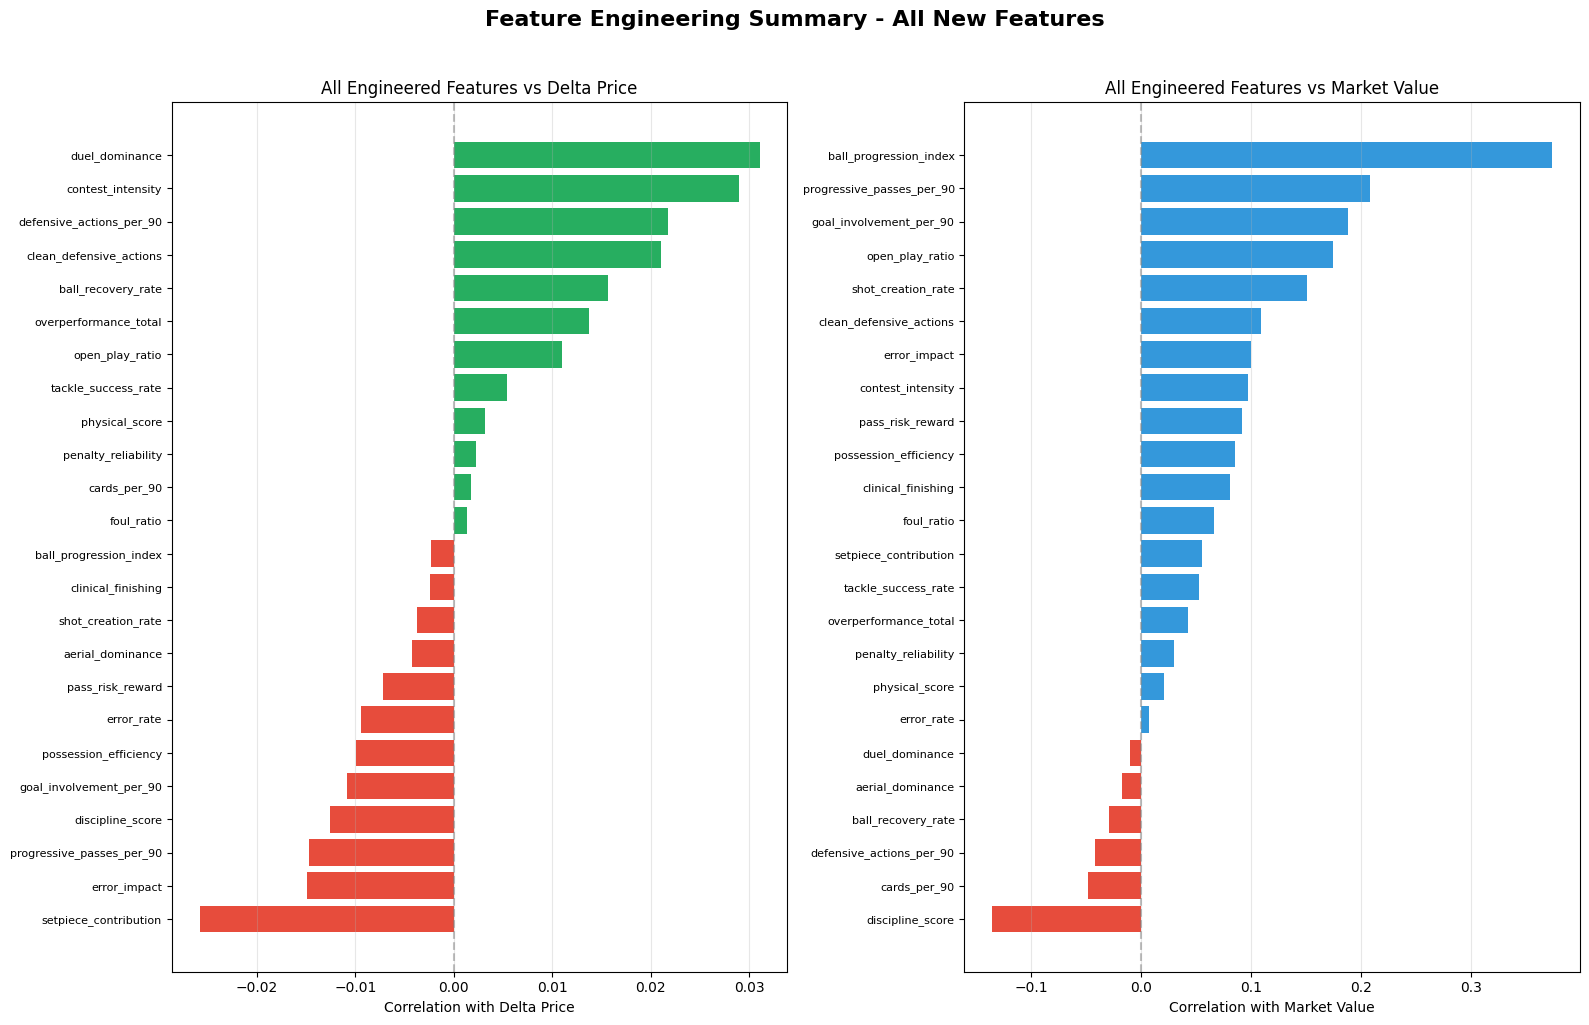


FEATURE ENGINEERING SUMMARY

📊 Total Engineered Features: 24

🔝 Top 5 Features for Delta Price Prediction:
   1. duel_dominance: 0.0310 ↑
   2. contest_intensity: 0.0290 ↑
   3. setpiece_contribution: -0.0258 ↓
   4. defensive_actions_per_90: 0.0217 ↑
   5. clean_defensive_actions: 0.0210 ↑

🔝 Top 5 Features for Market Value:
   1. ball_progression_index: 0.3735 ↑
   2. progressive_passes_per_90: 0.2076 ↑
   3. goal_involvement_per_90: 0.1884 ↑
   4. open_play_ratio: 0.1743 ↑
   5. shot_creation_rate: 0.1503 ↑

📋 Feature Groups Summary:
   Defensive: 5 features, mean |corr| with delta_price: 0.0146
   Attacking: 4 features, mean |corr| with delta_price: 0.0077
   Progression: 4 features, mean |corr| with delta_price: 0.0086
   Physical: 4 features, mean |corr| with delta_price: 0.0168
   Risk: 4 features, mean |corr| with delta_price: 0.0077
   Set Piece: 3 features, mean |corr| with delta_price: 0.0130


In [ ]:
all_engineered_feats = (defensive_feats + attacking_feats + 
                         progression_feats + physical_feats + 
                         risk_feats + setpiece_feats)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle('Feature Engineering Summary - All New Features', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0]
corr_delta = df[all_engineered_feats + ['delta_price']].corr()['delta_price'].drop('delta_price').sort_values()
colors = ['#e74c3c' if v < 0 else '#27ae60' for v in corr_delta.values]
ax1.barh(range(len(corr_delta)), corr_delta.values, color=colors)
ax1.set_yticks(range(len(corr_delta)))
ax1.set_yticklabels(corr_delta.index, fontsize=8)
ax1.set_xlabel('Correlation with Delta Price')
ax1.set_title('All Engineered Features vs Delta Price')
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

ax2 = axes[1]
corr_mv = df[all_engineered_feats + ['MarketValueCurrent']].corr()['MarketValueCurrent'].drop('MarketValueCurrent').sort_values()
colors = ['#e74c3c' if v < 0 else '#3498db' for v in corr_mv.values]
ax2.barh(range(len(corr_mv)), corr_mv.values, color=colors)
ax2.set_yticks(range(len(corr_mv)))
ax2.set_yticklabels(corr_mv.index, fontsize=8)
ax2.set_xlabel('Correlation with Market Value')
ax2.set_title('All Engineered Features vs Market Value')
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}")
print(f"\n Total Engineered Features: {len(all_engineered_feats)}")
print(f"\n Top 5 Features for Delta Price Prediction:")
top_delta = corr_delta.abs().sort_values(ascending=False).head(5)
for i, (feat, val) in enumerate(top_delta.items(), 1):
    actual_corr = corr_delta[feat]
    direction = "↑" if actual_corr > 0 else "↓"
    print(f"   {i}. {feat}: {actual_corr:.4f} {direction}")

print(f"\n Top 5 Features for Market Value:")
top_mv = corr_mv.abs().sort_values(ascending=False).head(5)
for i, (feat, val) in enumerate(top_mv.items(), 1):
    actual_corr = corr_mv[feat]
    direction = "↑" if actual_corr > 0 else "↓"
    print(f"   {i}. {feat}: {actual_corr:.4f} {direction}")

print(f"\n Feature Groups Summary:")
groups = {
    'Defensive': defensive_feats,
    'Attacking': attacking_feats,
    'Progression': progression_feats,
    'Physical': physical_feats,
    'Risk': risk_feats,
    'Set Piece': setpiece_feats
}
for group_name, feats in groups.items():
    mean_corr = df[feats + ['delta_price']].corr()['delta_price'].drop('delta_price').abs().mean()
    print(f"   {group_name}: {len(feats)} features, mean |corr| with delta_price: {mean_corr:.4f}")